# Training Random Forest and GBTrees with featrue-based dataset

Dataset with additional mesh-features  
`D:/ML4pmg/Data_Large23/mesh_features.csv `           unbalanced dataset    
`D:/ML4pmg/Data_Large23/balanced_mesh_features.csv `  balanced dataset    (shown to work better!)  

Dataset with additional fracture-features  
`D:/ML4pmg/Data_Large4/mesh_features.csv `           unbalanced dataset    
`D:/ML4pmg/Data_Large4/balanced_mesh_features.csv`   balanced dataset    

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns


from scipy.spatial import cKDTree


from sklearn.model_selection import train_test_split

### Stratified split of the dataset for training and test

For balanced dataset, in order to ensure every pattern is present for training and test

In [2]:

def stratified_train_test_split(df, test_size=0.2, random_state=42):
    train_parts = []
    test_parts = []

    for pattern_id, group in df.groupby('pattern_id'):
        train_group, test_group = train_test_split(
            group,
            test_size=test_size,
            random_state=random_state,
            shuffle=True
        )
        train_parts.append(train_group)
        test_parts.append(test_group)

    train_df = pd.concat(train_parts).reset_index(drop=True)
    test_df = pd.concat(test_parts).reset_index(drop=True)

    print(f"✅ Stratified split done. Train: {len(train_df)} samples, Test: {len(test_df)} samples.")
    return train_df, test_df


In [145]:
#balanced_df = pd.read_csv("D:/ML4pmg/Data_Large23/balanced_mesh_features.csv")
balanced_df = pd.read_csv("D:/ML4pmg/Data_Large4/balanced_mesh_features.csv")
train_df, test_df = stratified_train_test_split(balanced_df, test_size=0.2)


✅ Stratified split done. Train: 1280 samples, Test: 320 samples.


## Classification

In [146]:
# Prepare features and target
feature_cols = [col for col in train_df.columns if not col.startswith('y_') and col not in ['mesh_id', 'mesh_name', 'convergence_pattern', 'pattern_id']]
X_train = train_df[feature_cols].values
y_train = train_df['pattern_id'].values

X_test = test_df[feature_cols].values
y_test = test_df['pattern_id'].values

### Random Forest for Classification

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

n_esti=100; rndm_state=24

# Train Random Forest
clf = RandomForestClassifier(n_estimators=n_esti, random_state=rndm_state)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.68      0.57      0.62        40
           1       0.47      0.38      0.42        40
           2       0.58      0.65      0.61        40
           3       0.76      0.62      0.68        40
           4       0.64      0.57      0.61        40
           5       0.75      0.95      0.84        40
           6       0.72      0.85      0.78        40
           7       0.71      0.75      0.73        40

    accuracy                           0.67       320
   macro avg       0.66      0.67      0.66       320
weighted avg       0.66      0.67      0.66       320

Confusion Matrix:
 [[23  1  6  0  5  0  0  5]
 [ 1 15  3  6  5  0 10  0]
 [ 4  1 26  0  2  0  0  7]
 [ 0  7  0 25  0  8  0  0]
 [ 3  8  3  1 23  0  2  0]
 [ 0  0  0  1  0 38  1  0]
 [ 0  0  0  0  1  5 34  0]
 [ 3  0  7  0  0  0  0 30]]


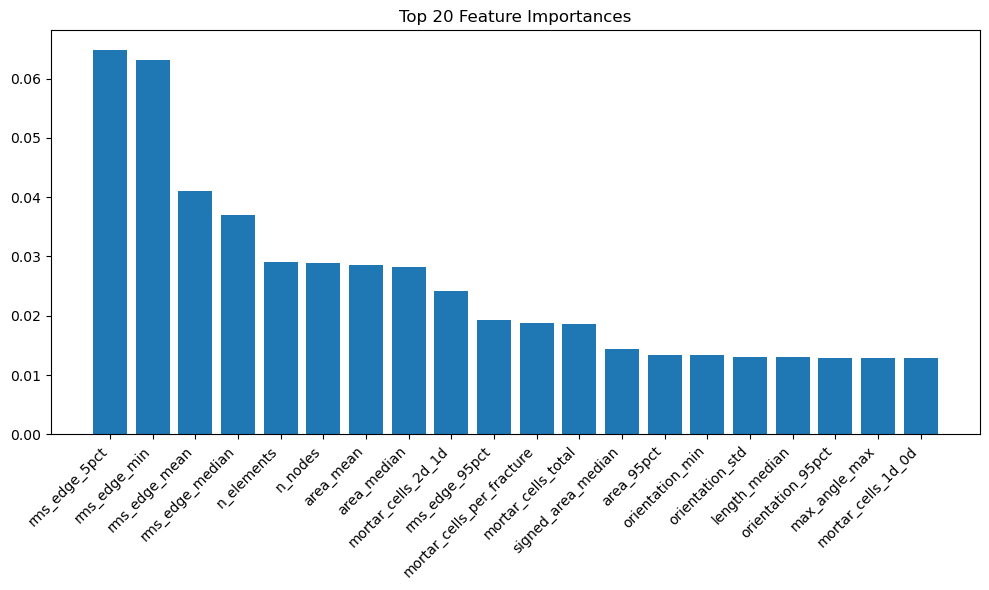

In [148]:

importances = clf.feature_importances_
feature_names = feature_cols  # as defined earlier

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[sorted_idx[:20]])
plt.xticks(range(20), [feature_names[i] for i in sorted_idx[:20]], rotation=45, ha='right')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [149]:
from scipy.stats import entropy

def compute_uncertainty_measures(y_proba):
    confidence = np.max(y_proba, axis=1)
    sorted_proba = np.sort(y_proba, axis=1)[:, ::-1]
    margin = sorted_proba[:, 0] - sorted_proba[:, 1]
    entropy_scores = entropy(y_proba.T,base =2) / np.log2(y_proba.shape[1])
        
    return confidence, margin, entropy_scores 


In [150]:
y_proba = clf.predict_proba(X_test)

confidence, margin, entropy = compute_uncertainty_measures(y_proba)

for i in range(5):
    print(f"Sample {i}: Confidence={confidence[i]:.2f}, Margin={margin[i]:.2f}, Entropy={entropy[i]:.2f}")


Sample 0: Confidence=0.77, Margin=0.65, Entropy=0.36
Sample 1: Confidence=0.26, Margin=0.00, Entropy=0.79
Sample 2: Confidence=0.56, Margin=0.29, Entropy=0.51
Sample 3: Confidence=0.77, Margin=0.62, Entropy=0.35
Sample 4: Confidence=0.32, Margin=0.11, Entropy=0.75


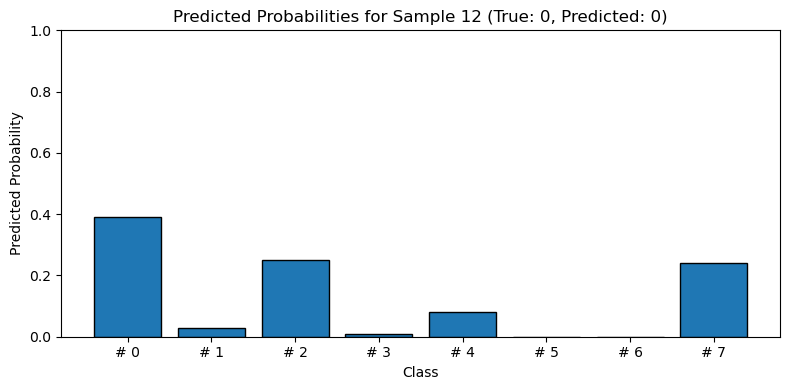

In [151]:
def plot_prediction_probabilities(y_proba_sample, class_labels=None, title="Prediction Probabilities"):
    plt.figure(figsize=(8, 4))
    classes = np.arange(len(y_proba_sample))
    plt.bar(classes, y_proba_sample, edgecolor='black')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Predicted Probability")
    if class_labels is not None:
        plt.xticks(classes, class_labels)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# Example usage:
sample_index = 12  # Choose which test sample to plot
plot_prediction_probabilities(
    y_proba[sample_index],
    class_labels=[f"# {i}" for i in range(y_proba.shape[1])],
    title=f"Predicted Probabilities for Sample {sample_index} (True: {y_test[sample_index]}, Predicted: {y_pred[sample_index]})"
)


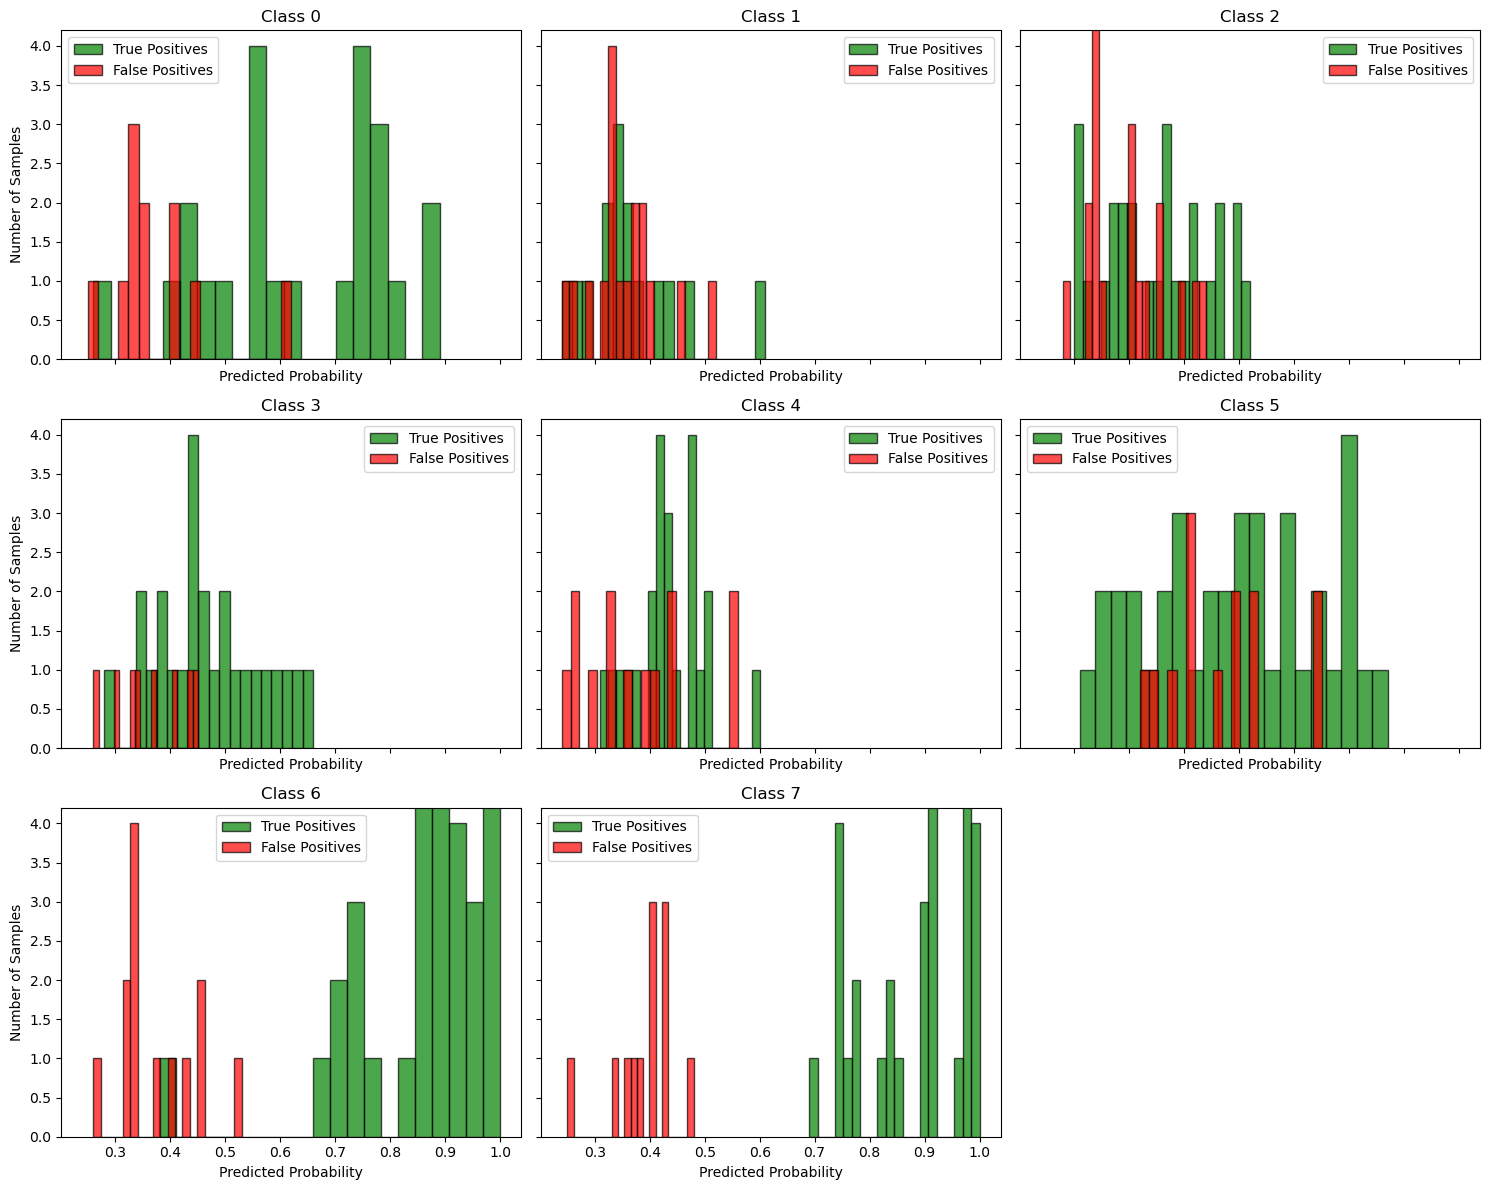

In [152]:

n_classes = y_proba.shape[1]
n_cols = 3
n_rows = int(np.ceil(n_classes / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True, sharex=True)
axs = axs.flatten()

for class_idx in range(n_classes):
    ax = axs[class_idx]
    
    # True Positives: true == class_idx and predicted == class_idx
    tp_mask = (y_test == class_idx) & (y_pred == class_idx)
    
    # False Positives: true != class_idx and predicted == class_idx
    fp_mask = (y_test != class_idx) & (y_pred == class_idx)
    
    ax.hist(
        y_proba[tp_mask, class_idx], bins=20, color='green', alpha=0.7,
        label='True Positives', edgecolor='black'
    )
    ax.hist(
        y_proba[fp_mask, class_idx], bins=20, color='red', alpha=0.7,
        label='False Positives', edgecolor='black'
    )

    ax.set_title(f"Class {class_idx}")
    ax.set_xlabel("Predicted Probability")
    ax.set_ylim(0, None)
    if class_idx % n_cols == 0:
        ax.set_ylabel("Number of Samples")
    ax.legend()

# Hide unused axes
for idx in range(n_classes, len(axs)):
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


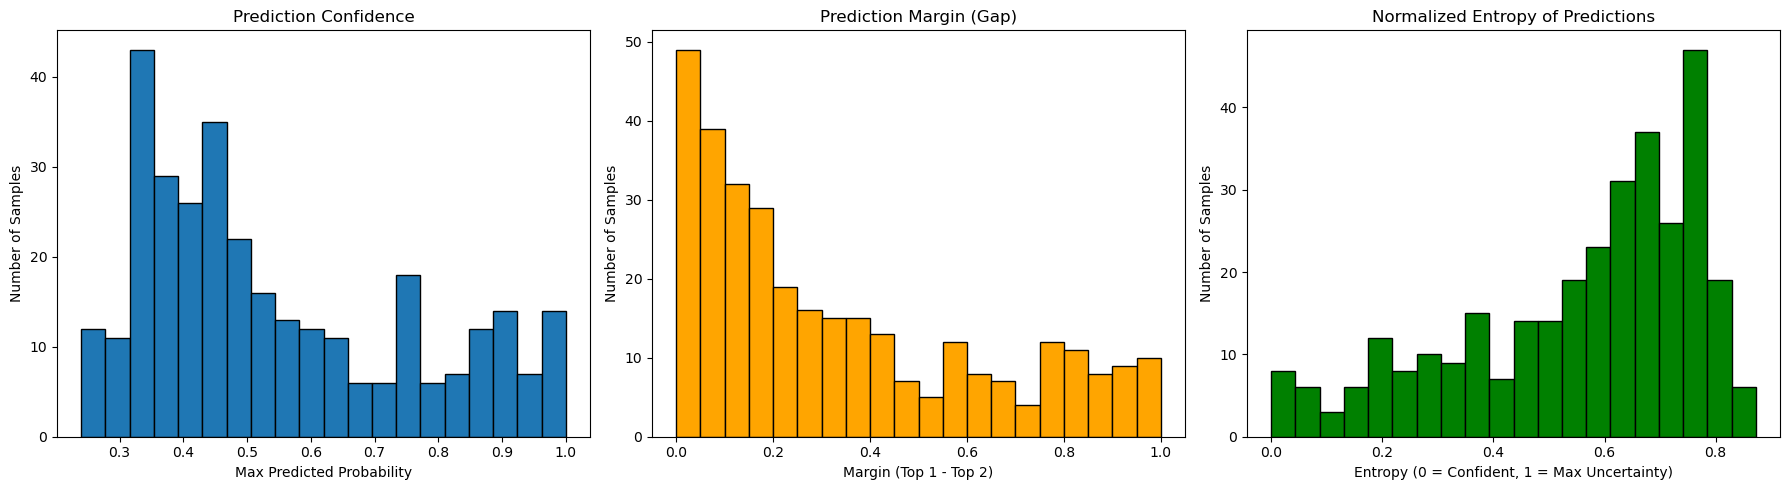

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Confidence histogram
axs[0].hist(confidence, bins=20, edgecolor='black')
axs[0].set_title("Prediction Confidence")
axs[0].set_xlabel("Max Predicted Probability")
axs[0].set_ylabel("Number of Samples")

# Margin histogram
axs[1].hist(margin, bins=20, edgecolor='black', color='orange')
axs[1].set_title("Prediction Margin (Gap)")
axs[1].set_xlabel("Margin (Top 1 - Top 2)")
axs[1].set_ylabel("Number of Samples")

# Normalized Entropy histogram
axs[2].hist(entropy, bins=20, edgecolor='black', color='green')
axs[2].set_title("Normalized Entropy of Predictions")
axs[2].set_xlabel("Entropy (0 = Confident, 1 = Max Uncertainty)")
axs[2].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()




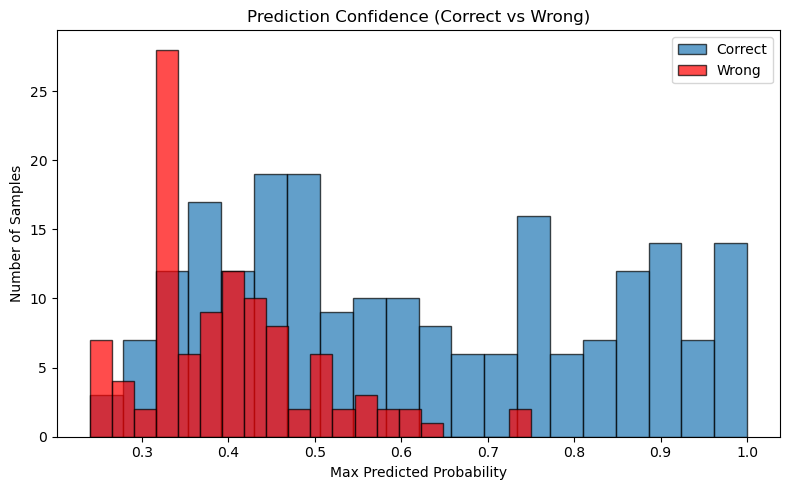

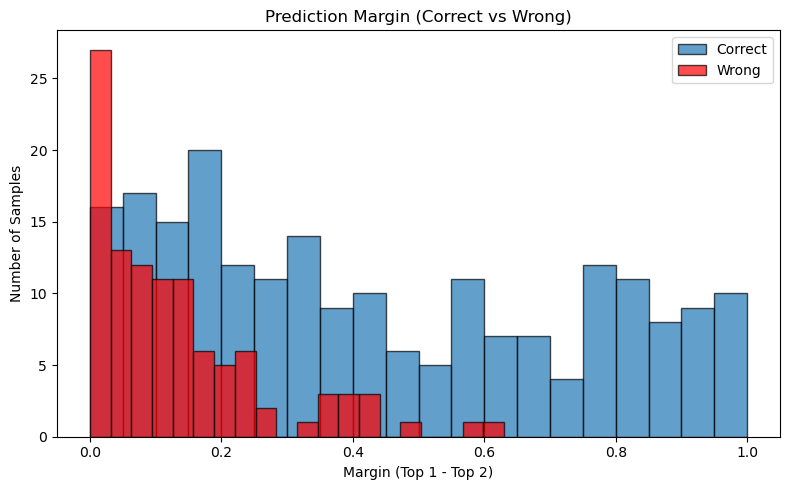

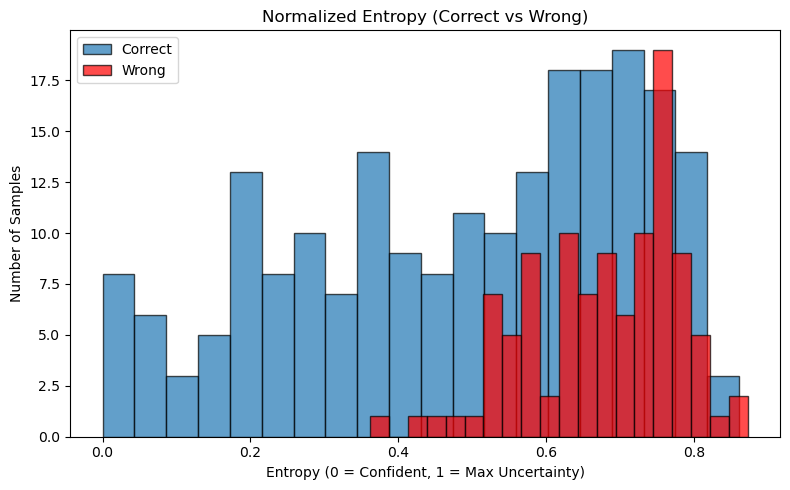

In [154]:

# Assuming you have:
# y_test — true labels
# y_pred — predicted labels
# confidence, margin, normalized_entropy — computed uncertainty measures

# Create masks
correct_mask = y_test == y_pred
wrong_mask = ~correct_mask

# Plotting function
def plot_histograms_split(metric, correct_vals, wrong_vals, title, xlabel):
    plt.figure(figsize=(8, 5))
    plt.hist(correct_vals, bins=20, alpha=0.7, label="Correct", edgecolor='black')
    plt.hist(wrong_vals, bins=20, alpha=0.7, label="Wrong", edgecolor='black', color='red')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Number of Samples")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot for Confidence
plot_histograms_split(
    confidence, 
    confidence[correct_mask], 
    confidence[wrong_mask], 
    "Prediction Confidence (Correct vs Wrong)", 
    "Max Predicted Probability"
)

# Plot for Margin
plot_histograms_split(
    margin, 
    margin[correct_mask], 
    margin[wrong_mask], 
    "Prediction Margin (Correct vs Wrong)", 
    "Margin (Top 1 - Top 2)"
)

# Plot for Normalized Entropy
plot_histograms_split(
    entropy, 
    entropy[correct_mask], 
    entropy[wrong_mask], 
    "Normalized Entropy (Correct vs Wrong)", 
    "Entropy (0 = Confident, 1 = Max Uncertainty)"
)


In [155]:
y_pred_class = y_pred

### Exploring Feature Importance

#### Impurity Importance and Permutation imporatance

In [156]:

def plot_impurity_importance(clf, feature_names, top_n=30, model_name="Random Forest"):
    importances = clf.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:top_n][::-1], importance_df['Importance'][:top_n][::-1])
    plt.xlabel("Impurity-Based Importance")
    plt.title(f"Top {top_n} Feature Importances for {model_name}")
    plt.tight_layout()
    plt.show()

    return importance_df




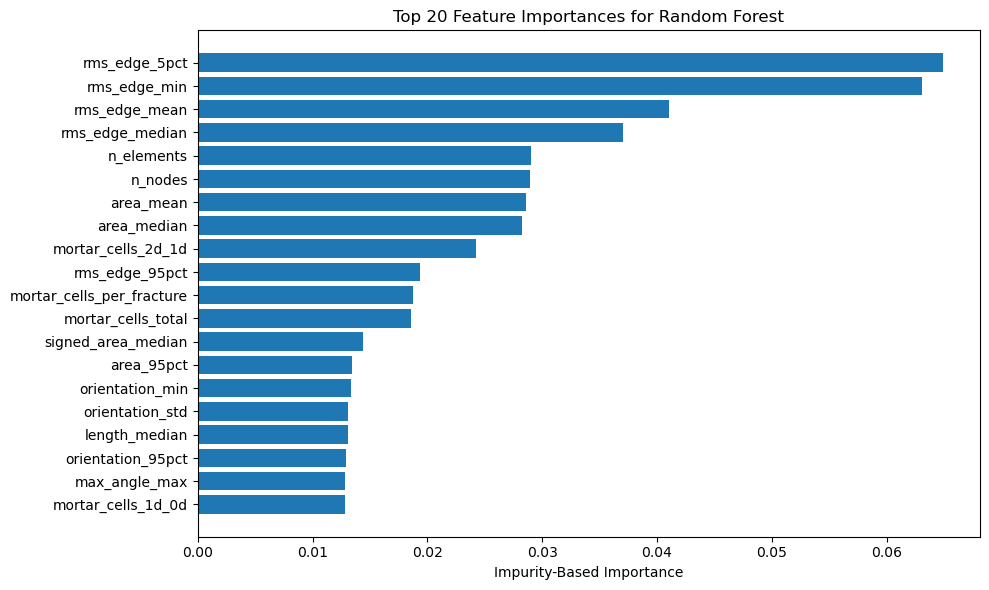

In [157]:
# Already trained classifier (clf), and feature_cols = list of feature names
importance_df = plot_impurity_importance(clf, feature_cols, top_n=20)


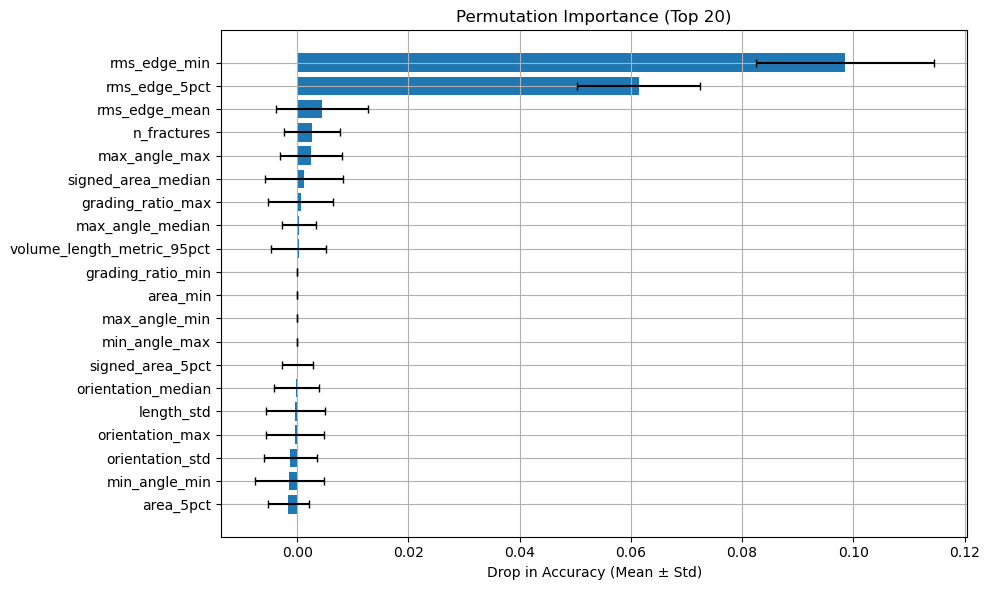

In [158]:
from sklearn.inspection import permutation_importance


# Compute permutation importance
result = permutation_importance(
    clf, X_test, y_test,
    n_repeats=20,  # More = smoother, slower
    random_state=42,
    n_jobs=-1  # Use all cores
)

# Wrap results in a DataFrame
perm_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)



# Plot top patterns
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'][:top_n][::-1], perm_df['Importance Mean'][:top_n][::-1],
         xerr=perm_df['Importance Std'][:top_n][::-1], capsize=3)
plt.xlabel("Drop in Accuracy (Mean ± Std)")
plt.title(f"Permutation Importance (Top {top_n})")
plt.tight_layout()
plt.grid(True)
plt.show()

Removing few top feature and re-fitting to see the result

In [ ]:
# aux =importance_df['Feature'][2::].values.tolist()
# aux


In [249]:
# Get top N most important features from permutation importance
top_n = 2  # Try with 1, then 2, then 3
features_to_remove = perm_df['Feature'].iloc[:top_n].tolist()
features_left = perm_df['Feature'].iloc[top_n:].tolist()

print("Removing:", features_to_remove)

# Create reduced training and test sets
X_train_reduced = pd.DataFrame(X_train, columns=feature_cols).drop(columns=features_to_remove)
X_test_reduced = pd.DataFrame(X_test, columns=feature_cols).drop(columns=features_to_remove)

# Fit a new Random Forest
from sklearn.ensemble import RandomForestClassifier
clf_reduced = RandomForestClassifier(n_estimators=n_esti, random_state=rndm_state)
clf_reduced.fit(X_train_reduced, y_train)

# Evaluate


y_pred_reduced = clf_reduced.predict(X_test_reduced)
print("Accuracy after removing top features:", accuracy_score(y_test, y_pred_reduced))
print(classification_report(y_test, y_pred_reduced))


Removing: ['rms_edge_min', 'rms_edge_5pct']
Accuracy after removing top features: 0.559375
              precision    recall  f1-score   support

           0       0.53      0.45      0.49        40
           1       0.24      0.20      0.22        40
           2       0.48      0.55      0.51        40
           3       0.75      0.53      0.62        40
           4       0.32      0.28      0.30        40
           5       0.70      0.88      0.78        40
           6       0.64      0.85      0.73        40
           7       0.73      0.75      0.74        40

    accuracy                           0.56       320
   macro avg       0.55      0.56      0.55       320
weighted avg       0.55      0.56      0.55       320



The accuracy dropped, but not for the class 5. It is worth to investigate the reason behind this further! In a bit, we will investigate Class 5. But first, lets prune the forest.

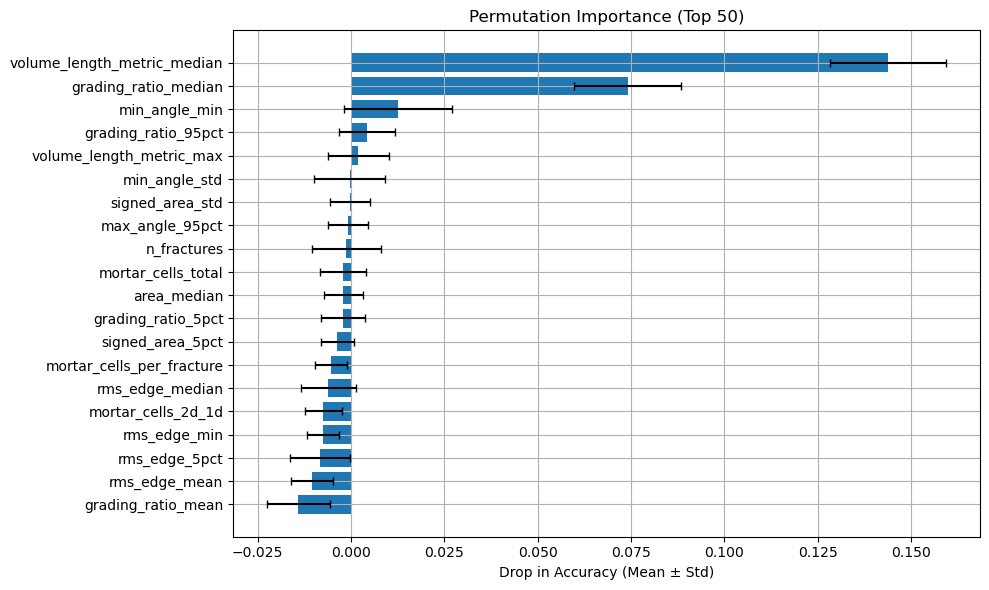

In [364]:

# Compute permutation importance
result = permutation_importance(
    clf_reduced, X_test_reduced, y_test,
    n_repeats=20,  # More = smoother, slower
    random_state=42,
    n_jobs=-1  # Use all cores
)

# Wrap results in a DataFrame
perm_df = pd.DataFrame({
    'Feature': features_left,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Plot top patterns
top_n = 50
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'][:top_n][::-1], perm_df['Importance Mean'][:top_n][::-1],
         xerr=perm_df['Importance Std'][:top_n][::-1], capsize=3)
plt.xlabel("Drop in Accuracy (Mean ± Std)")
plt.title(f"Permutation Importance (Top {top_n})")
plt.tight_layout()
plt.grid(True)
plt.show()

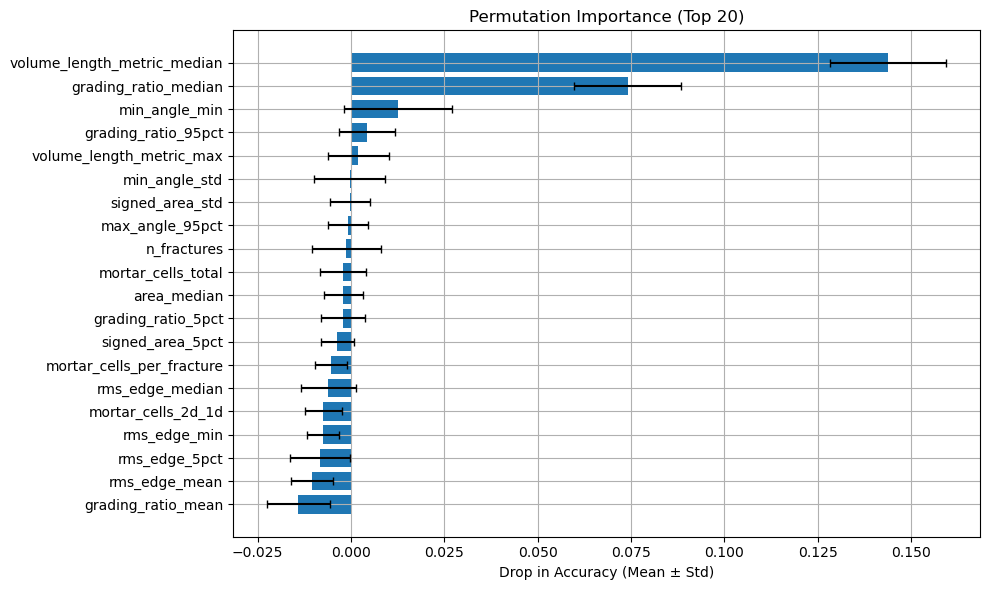

In [365]:
# Plot top patterns
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'][:top_n][::-1], perm_df['Importance Mean'][:top_n][::-1],
         xerr=perm_df['Importance Std'][:top_n][::-1], capsize=3)
plt.xlabel("Drop in Accuracy (Mean ± Std)")
plt.title(f"Permutation Importance (Top {top_n})")
plt.tight_layout()
plt.grid(True)
plt.show()

In [254]:
# Get top N most important features from permutation importance
top_n = 2  # Try with 1, then 2, then 3
features_to_remove = perm_df['Feature'].iloc[:top_n].tolist()


print("Removing:", features_to_remove)

# Create reduced training and test sets
X_train_reduced = pd.DataFrame(X_train_reduced, columns=features_left).drop(columns=features_to_remove)
X_test_reduced = pd.DataFrame(X_test_reduced, columns=features_left).drop(columns=features_to_remove)
features_left = perm_df['Feature'].iloc[top_n:].tolist()

clf_reduced = RandomForestClassifier(n_estimators=n_esti, random_state=rndm_state)
clf_reduced.fit(X_train_reduced, y_train)

# Evaluate


y_pred_reduced = clf_reduced.predict(X_test_reduced)
print("Accuracy after removing top features:", accuracy_score(y_test, y_pred_reduced))
print(classification_report(y_test, y_pred_reduced))

Removing: ['volume_length_metric_median', 'domain_span_x']
Accuracy after removing top features: 0.565625
              precision    recall  f1-score   support

           0       0.55      0.45      0.49        40
           1       0.29      0.30      0.29        40
           2       0.50      0.60      0.55        40
           3       0.69      0.50      0.58        40
           4       0.36      0.25      0.29        40
           5       0.70      0.82      0.76        40
           6       0.65      0.85      0.74        40
           7       0.73      0.75      0.74        40

    accuracy                           0.57       320
   macro avg       0.56      0.57      0.56       320
weighted avg       0.56      0.57      0.56       320



#### Pruning the forest

In [263]:
threshold = 0.01

low_importance = perm_df[
    (perm_df['Importance Mean'] + perm_df['Importance Std']) < threshold
]['Feature'].tolist()

print(f"{len(low_importance)} features to drop:", low_importance)


65 features to drop: ['grading_ratio_median', 'volume_length_metric_median', 'mortar_cells_per_fracture', 'volume_length_metric_max', 'grading_ratio_5pct', 'mortar_cells_total', 'grading_ratio_95pct', 'max_angle_95pct', 'signed_area_5pct', 'signed_area_std', 'grading_ratio_mean', 'min_angle_std', 'max_angle_median', 'rms_edge_max', 'orientation_5pct', 'signed_area_95pct', 'orientation_max', 'grading_ratio_std', 'rms_edge_std', 'orientation_min', 'orientation_std', 'mortar_cells_1d_0d', 'max_angle_5pct', 'area_std', 'grading_ratio_max', 'volume_length_metric_min', 'max_angle_max', 'max_angle_mean', 'rms_edge_95pct', 'length_5pct', 'min_angle_5pct', 'volume_length_metric_std', 'area_5pct', 'max_angle_min', 'area_min', 'grading_ratio_min', 'min_angle_max', 'orientation_median', 'orientation_mean', 'length_mean', 'min_angle_median', 'min_angle_mean', 'volume_length_metric_mean', 'length_max', 'length_std', 'area_mean', 'length_min', 'domain_span_y', 'min_angle_95pct', 'length_95pct', 'doma

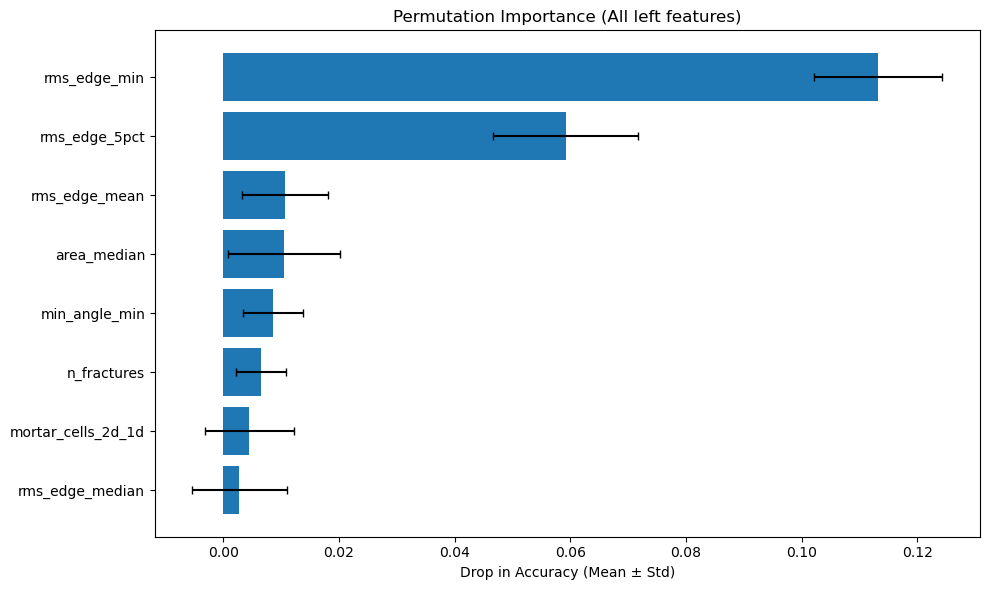

In [264]:
# Plot top patterns

perm_df_reduced = perm_df[~perm_df['Feature'].isin(low_importance)]
plt.figure(figsize=(10, 6))
plt.barh(perm_df_reduced['Feature'][::-1], perm_df_reduced['Importance Mean'][::-1],
         xerr=perm_df_reduced['Importance Std'][::-1], capsize=3)
plt.xlabel("Drop in Accuracy (Mean ± Std)")
plt.title(f"Permutation Importance (All left features)")
plt.tight_layout()
plt.show()

Drop the features and Re-train the model

Model train on high-importance features:

In [265]:
# Drop from training and test sets
X_train_pruned = pd.DataFrame(X_train, columns=feature_cols).drop(columns=low_importance)
X_test_pruned = pd.DataFrame(X_test, columns=feature_cols).drop(columns=low_importance)

# Retrain model
clf_pruned = RandomForestClassifier(n_estimators=n_esti, random_state=rndm_state)
clf_pruned.fit(X_train_pruned, y_train)

# Evaluate

y_pred_pruned = clf_pruned.predict(X_test_pruned)


print("Accuracy after pruning:", accuracy_score(y_test, y_pred_pruned))
print(classification_report(y_test, y_pred_pruned))


Accuracy after pruning: 0.646875
              precision    recall  f1-score   support

           0       0.77      0.60      0.68        40
           1       0.39      0.33      0.36        40
           2       0.61      0.57      0.59        40
           3       0.65      0.65      0.65        40
           4       0.69      0.60      0.64        40
           5       0.74      0.80      0.77        40
           6       0.69      0.85      0.76        40
           7       0.61      0.78      0.68        40

    accuracy                           0.65       320
   macro avg       0.64      0.65      0.64       320
weighted avg       0.64      0.65      0.64       320



Model train on top 20 permutation importance features:

In [159]:

top_n = 20  # Keep top 20
features_to_remove = perm_df['Feature'].iloc[top_n::].tolist()
features_left = perm_df['Feature'].iloc[0:top_n].tolist()

print("Removing:", features_to_remove)

# Create reduced training and test sets
X_train_reduced = pd.DataFrame(X_train, columns=feature_cols).drop(columns=features_to_remove)
X_test_reduced = pd.DataFrame(X_test, columns=feature_cols).drop(columns=features_to_remove)

# Fit a new Random Forest
from sklearn.ensemble import RandomForestClassifier
clf_reduced = RandomForestClassifier(n_estimators=200, random_state=42)
clf_reduced.fit(X_train_reduced, y_train)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score

y_pred_reduced = clf_reduced.predict(X_test_reduced)
print("Accuracy with top features:", accuracy_score(y_test, y_pred_reduced))
print(classification_report(y_test, y_pred_reduced))

Removing: ['fracture_density', 'max_angle_5pct', 'grading_ratio_median', 'length_median', 'max_angle_mean', 'domain_span_x', 'signed_area_min', 'min_angle_std', 'mortar_cells_total', 'min_angle_median', 'rms_edge_median', 'mortar_cells_2d_1d', 'length_mean', 'orientation_95pct', 'signed_area_95pct', 'length_max', 'length_min', 'grading_ratio_95pct', 'volume_length_metric_max', 'length_5pct', 'grading_ratio_std', 'volume_length_metric_5pct', 'volume_length_metric_mean', 'orientation_min', 'grading_ratio_5pct', 'min_angle_mean', 'area_max', 'min_angle_5pct', 'signed_area_mean', 'grading_ratio_mean', 'length_95pct', 'rms_edge_std', 'area_std', 'signed_area_max', 'mortar_cells_1d_0d', 'orientation_mean', 'max_angle_95pct', 'area_median', 'n_nodes', 'volume_length_metric_min', 'signed_area_std', 'orientation_5pct', 'volume_length_metric_median', 'mortar_cells_per_fracture', 'min_angle_95pct', 'volume_length_metric_std', 'rms_edge_max', 'domain_span_y', 'n_elements', 'max_angle_std', 'area_9

Keep top 20 impurity importance features

In [267]:
top_n = 20  # Keep top 20
features_to_remove = importance_df['Feature'].iloc[top_n::].tolist()

print("Removing:", features_to_remove)

# Create reduced training and test sets
X_train_reduced = pd.DataFrame(X_train, columns=feature_cols).drop(columns=features_to_remove)
X_test_reduced = pd.DataFrame(X_test, columns=feature_cols).drop(columns=features_to_remove)

# Fit a new Random Forest
from sklearn.ensemble import RandomForestClassifier
clf_reduced = RandomForestClassifier(n_estimators=n_esti, random_state=rndm_state)
clf_reduced.fit(X_train_reduced, y_train)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score

y_pred_reduced = clf_reduced.predict(X_test_reduced)
print("Accuracy with top features:", accuracy_score(y_test, y_pred_reduced))
print(classification_report(y_test, y_pred_reduced))

Removing: ['signed_area_mean', 'signed_area_std', 'min_angle_min', 'length_median', 'orientation_max', 'orientation_min', 'length_5pct', 'area_std', 'orientation_95pct', 'grading_ratio_std', 'orientation_mean', 'domain_span_x', 'length_mean', 'length_min', 'orientation_median', 'orientation_5pct', 'grading_ratio_max', 'fracture_density', 'length_95pct', 'rms_edge_max', 'volume_length_metric_std', 'max_angle_std', 'min_angle_std', 'domain_span_y', 'grading_ratio_median', 'grading_ratio_mean', 'max_angle_95pct', 'max_angle_5pct', 'min_angle_5pct', 'length_std', 'length_max', 'area_max', 'min_angle_95pct', 'volume_length_metric_95pct', 'max_angle_median', 'volume_length_metric_5pct', 'min_angle_median', 'min_angle_mean', 'n_fractures', 'max_angle_mean', 'volume_length_metric_mean', 'volume_length_metric_median', 'signed_area_95pct', 'signed_area_5pct', 'volume_length_metric_max', 'signed_area_min', 'volume_length_metric_min', 'area_5pct', 'signed_area_max', 'max_angle_min', 'min_angle_max

#################################################################
Previous investigations
#################################################################

#### What is special with Class 5?

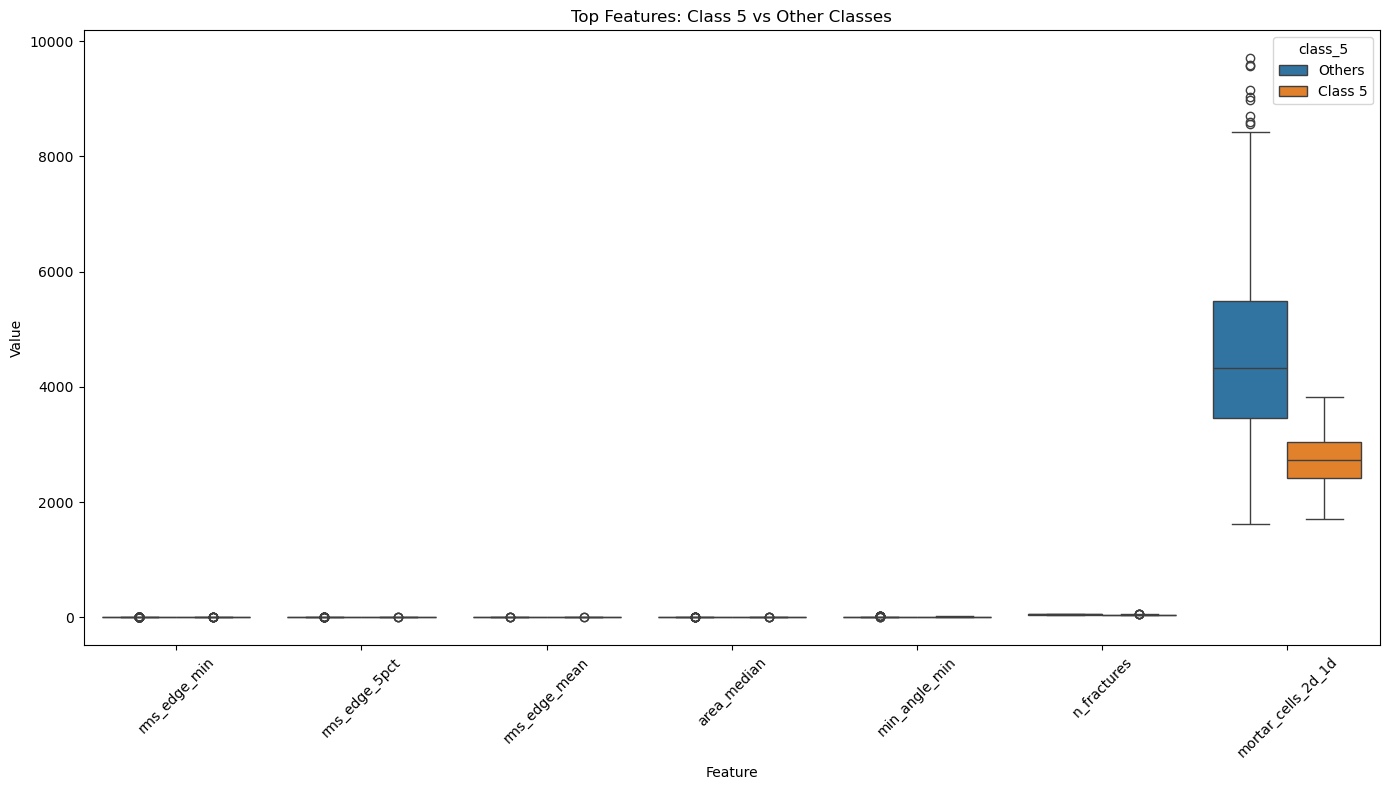

In [289]:

# Assumes you already have:
# - X_train_pruned: DataFrame with pruned features
# - y_train: array-like labels
# - perm_df: DataFrame with permutation importance results

# Step 1: Add labels
df = X_train_pruned.copy()
df['label'] = y_train

# Step 2: Create binary group: Class 5 vs Others
df['class_5'] = df['label'].apply(lambda x: "Class 5" if x == 5 else "Others")

# Step 3: Select top N features that still exist in the pruned data
top_feats = features_left[:10]  # Adjust as needed
top_feats = [f for f in top_feats if f in df.columns]  # ensure feature exists

# Step 4: Melt for Seaborn boxplot
df_long = df[top_feats + ['class_5']].melt(id_vars='class_5', var_name='Feature', value_name='Value')

# Step 5: Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Feature', y='Value', hue='class_5', data=df_long)
plt.title("Top Features: Class 5 vs Other Classes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [290]:
top_feats

['rms_edge_min',
 'rms_edge_5pct',
 'rms_edge_mean',
 'area_median',
 'min_angle_min',
 'n_fractures',
 'mortar_cells_2d_1d']

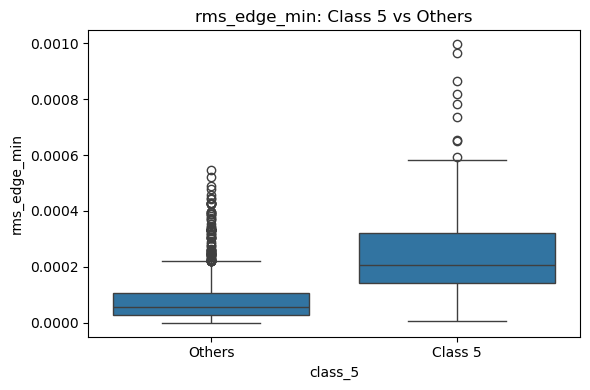

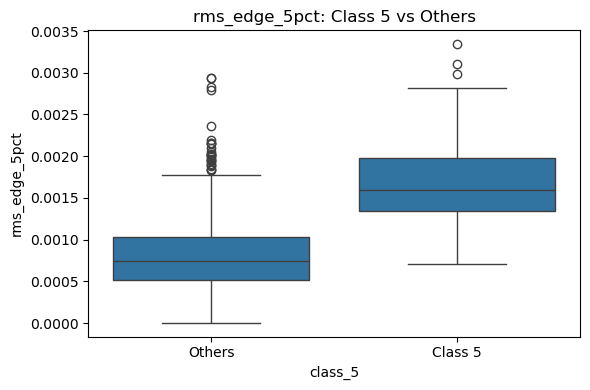

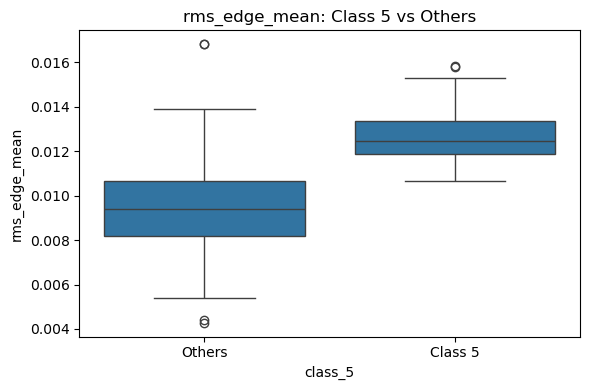

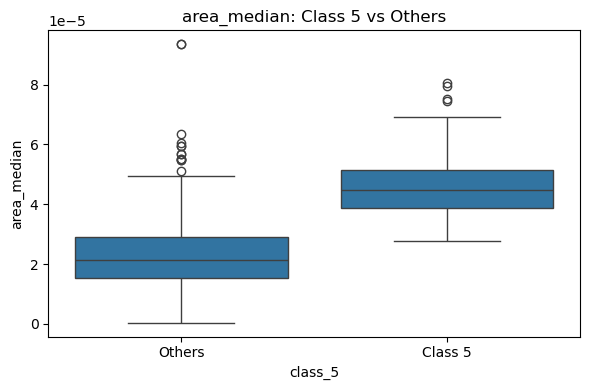

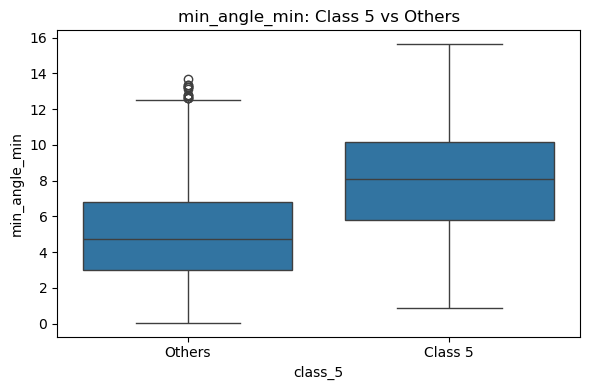

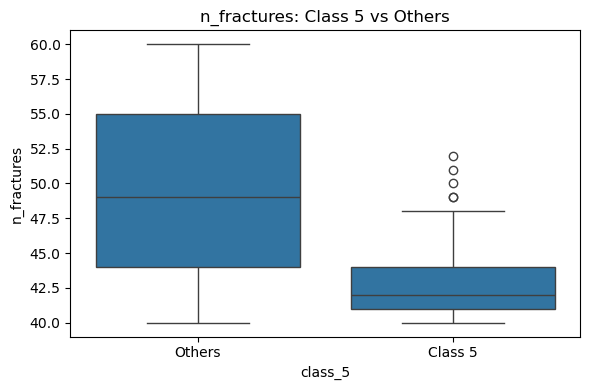

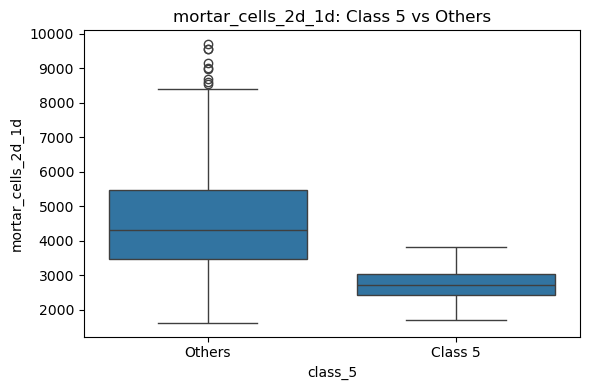

In [291]:
for feat in top_feats:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='class_5', y=feat, data=df)
    plt.title(f"{feat}: Class 5 vs Others")
    plt.tight_layout()
    plt.show()


Calculate the significance, if p<0.05 it is an indication that the difference between this feature is significant.
If p is larger, then the feature have overlapping distibutions

In [292]:
from scipy.stats import mannwhitneyu

for feat in top_feats:
    class5_vals = df[df['class_5'] == "Class 5"][feat]
    other_vals = df[df['class_5'] == "Others"][feat]
    stat, p = mannwhitneyu(class5_vals, other_vals, alternative='two-sided')
    print(f"{feat}: p = {p:.4f}")


rms_edge_min: p = 0.0000
rms_edge_5pct: p = 0.0000
rms_edge_mean: p = 0.0000
area_median: p = 0.0000
min_angle_min: p = 0.0000
n_fractures: p = 0.0000
mortar_cells_2d_1d: p = 0.0000


### Gradient Boosting Trees

In [293]:
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators=n_esti, random_state=rndm_state)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.68      0.68        40
           1       0.53      0.42      0.47        40
           2       0.67      0.60      0.63        40
           3       0.72      0.72      0.73        40
           4       0.66      0.62      0.64        40
           5       0.73      0.82      0.78        40
           6       0.76      0.88      0.81        40
           7       0.68      0.75      0.71        40

    accuracy                           0.69       320
   macro avg       0.68      0.69      0.68       320
weighted avg       0.68      0.69      0.68       320

Confusion Matrix:
 [[27  0  1  0  7  0  0  5]
 [ 1 17  5  4  5  2  6  0]
 [ 2  2 24  2  1  0  0  9]
 [ 0  4  0 29  0  7  0  0]
 [ 5  6  1  1 25  0  2  0]
 [ 0  0  0  4  0 33  3  0]
 [ 0  2  0  0  0  3 35  0]
 [ 4  1  5  0  0  0  0 30]]


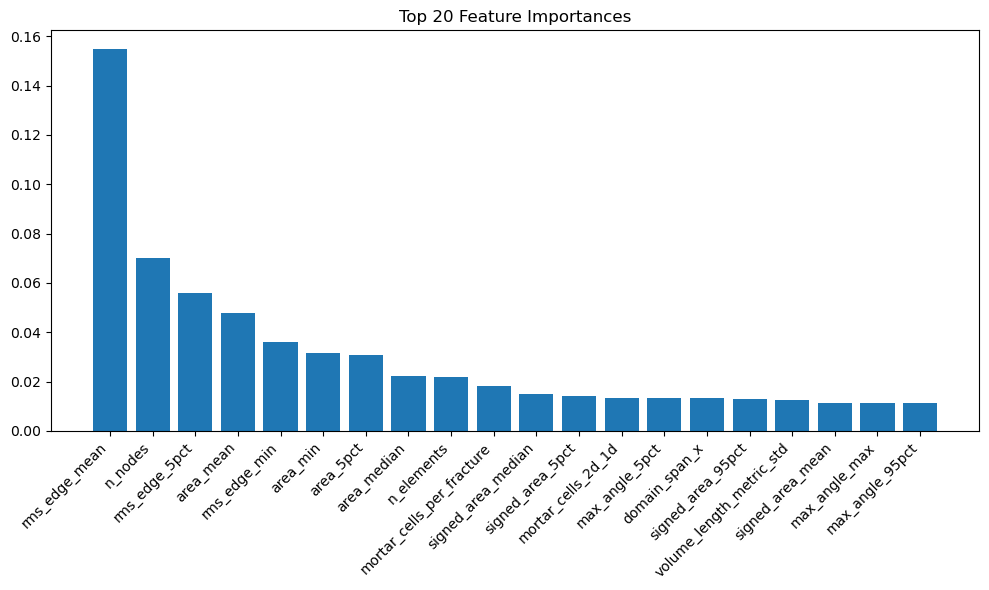

In [294]:
importances = clf.feature_importances_
feature_names = feature_cols  # as defined earlier

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[sorted_idx[:20]])
plt.xticks(range(20), [feature_names[i] for i in sorted_idx[:20]], rotation=45, ha='right')
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

#### With scaling, not too important for Random Forest and GB Trees, but for Logistic Regression! 

In [295]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [296]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.44      0.45      0.44        40
           1       0.50      0.33      0.39        40
           2       0.54      0.50      0.52        40
           3       0.58      0.65      0.61        40
           4       0.62      0.62      0.62        40
           5       0.65      0.78      0.70        40
           6       0.50      0.50      0.50        40
           7       0.42      0.45      0.43        40

    accuracy                           0.53       320
   macro avg       0.53      0.53      0.53       320
weighted avg       0.53      0.53      0.53       320

Confusion Matrix:
 [[18  0  4  0  5  0  0 13]
 [ 1 13  5  5  4  1 11  0]
 [ 7  0 20  1  3  0  0  9]
 [ 0  4  0 26  1  6  3  0]
 [ 2  6  1  1 25  0  2  3]
 [ 0  1  0  4  0 31  4  0]
 [ 0  2  0  8  0 10 20  0]
 [13  0  7  0  2  0  0 18]]


## Regression

- /mesh_features_annotated.csv for full dataset
- /balanced_mesh_features_annotated.csv for the balanced (with converence patterns) dataset 

In [166]:
#df = pd.read_csv("D:/ML4pmg/Data_Large4/mesh_features_annotated.csv")
df = pd.read_csv("D:/ML4pmg/Data_Large4/balanced_mesh_features.csv",  dtype={'convergence_pattern': str}) # Or balanced!

In [167]:
df['convergence_pattern']

0             1000001
1        100111000001
2                   0
3                   0
4        100110000000
            ...      
1595    1100111100111
1596     100111100111
1597     100110000000
1598          1000000
1599    1100111100111
Name: convergence_pattern, Length: 1600, dtype: object

In [169]:
expected_length = 18

# Pad with zeros on the left if needed
df['convergence_pattern'] = df['convergence_pattern'].apply(
    lambda x: str(x).zfill(expected_length)
)

# ✅ Check that they are correct now
print(df['convergence_pattern'].head().tolist())


['000000000001000001', '000000100111000001', '000000000000000000', '000000000000000000', '000000100110000000']


In [170]:
df['convergence_pattern']

0       000000000001000001
1       000000100111000001
2       000000000000000000
3       000000000000000000
4       000000100110000000
               ...        
1595    000001100111100111
1596    000000100111100111
1597    000000100110000000
1598    000000000001000000
1599    000001100111100111
Name: convergence_pattern, Length: 1600, dtype: object

### Remove columns with constact times (as some solvers never converge)

In [171]:

# Select all y_time_* columns
y_time_cols = [col for col in df.columns if col.startswith('y_time_')]


# Find the global minimum (the default value for diverged solver)
global_max_time = df[y_time_cols].min().min()

print(f"✅ Global max solver time: {global_max_time:.4f}")


# Identify non-constant targets (with variance > 0)
non_constant_y_time_cols = [
    col for col in y_time_cols if df[col].nunique() > 1
]

print("✅ Keeping targets:", non_constant_y_time_cols)
print("❌ Dropping targets:", set(y_time_cols) - set(non_constant_y_time_cols))

# Optionally, drop constant columns
filtered_df = df.drop(columns=list(set(y_time_cols) - set(non_constant_y_time_cols)))


✅ Global max solver time: -1.5790
✅ Keeping targets: ['y_time_5', 'y_time_6', 'y_time_9', 'y_time_10', 'y_time_11', 'y_time_12', 'y_time_15', 'y_time_16', 'y_time_17']
❌ Dropping targets: {'y_time_8', 'y_time_4', 'y_time_0', 'y_time_1', 'y_time_3', 'y_time_13', 'y_time_7', 'y_time_2', 'y_time_14'}


In [172]:
filtered_df.shape

(1600, 104)

In [173]:
filtered_df=filtered_df.drop(columns=features_to_remove)

In [174]:

# Get the indices of kept targets (assuming y_time_0, y_time_1, ...)
# Extract the integer suffix
kept_indices = sorted([
    int(col.replace('y_time_', ''))
    for col in non_constant_y_time_cols
])

print("✅ Kept solver indices:", kept_indices)

# Prepare the pattern id → reduced convergence pattern mapping
pattern_df = filtered_df[['pattern_id', 'convergence_pattern']].drop_duplicates().sort_values('pattern_id')
pattern_id_to_array = {
    row['pattern_id']: np.array([int(str(row['convergence_pattern'])[idx]) for idx in kept_indices])
    for _, row in pattern_df.iterrows()
}


print("✅ Pattern mapping with reduced dimention")
for pid in range(6):
    print(f"Pattern {pid}: {pattern_id_to_array[pid]}")


✅ Kept solver indices: [5, 6, 9, 10, 11, 12, 15, 16, 17]
✅ Pattern mapping with reduced dimention
Pattern 0: [0 0 0 0 0 0 0 0 0]
Pattern 1: [0 1 1 1 1 0 0 0 1]
Pattern 2: [0 0 0 0 1 0 0 0 1]
Pattern 3: [1 1 1 1 1 0 0 0 1]
Pattern 4: [0 1 1 1 0 0 0 0 0]
Pattern 5: [1 1 1 1 1 1 1 1 1]


In [175]:

# train_df, test_df = train_test_split(
#     filtered_df,
#     test_size=0.2,
#     random_state=42,
#     shuffle=True
# )

# print(f"✅ Random split done. Train: {len(train_df)} samples, Test: {len(test_df)} samples.")

# Or for balanced dataset
train_df, test_df = stratified_train_test_split(filtered_df, test_size=0.2)

✅ Stratified split done. Train: 1280 samples, Test: 320 samples.


In [176]:
# Select feature columns (exclude y_*, mesh_id, etc.)
feature_cols = [
    col for col in train_df.columns 
    if not col.startswith('y_') and col not in ['mesh_id', 'mesh_name', 'convergence_pattern', 'pattern_id']
]

# Select target columns (y_time_0 to y_time_17)
target_cols = [col for col in train_df.columns if col.startswith('y_time_')]

# Prepare training and test sets
X_train = train_df[feature_cols].values
y_train = train_df[target_cols].values # already log transformed!

X_test = test_df[feature_cols].values
y_test = test_df[target_cols].values


In [177]:
train_df.columns

Index(['mesh_name', 'mesh_id', 'n_fractures', 'area_5pct', 'area_min',
       'signed_area_median', 'signed_area_5pct', 'rms_edge_mean',
       'rms_edge_5pct', 'rms_edge_min', 'volume_length_metric_95pct',
       'min_angle_min', 'min_angle_max', 'max_angle_median', 'max_angle_min',
       'max_angle_max', 'grading_ratio_min', 'grading_ratio_max', 'y_time_5',
       'y_time_6', 'y_time_9', 'y_time_10', 'y_time_11', 'y_time_12',
       'y_time_15', 'y_time_16', 'y_time_17', 'y_conv_0', 'y_conv_1',
       'y_conv_2', 'y_conv_3', 'y_conv_4', 'y_conv_5', 'y_conv_6', 'y_conv_7',
       'y_conv_8', 'y_conv_9', 'y_conv_10', 'y_conv_11', 'y_conv_12',
       'y_conv_13', 'y_conv_14', 'y_conv_15', 'y_conv_16', 'y_conv_17',
       'length_std', 'orientation_median', 'orientation_std',
       'orientation_max', 'convergence_pattern', 'pattern_id'],
      dtype='object')

## Random Forest Regressor

OBS!! WE need to balance the data differently! Think about this...


In [178]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


n_esti=100; rndm_state=24
# Initialize RandomForestRegressor
regressor = RandomForestRegressor(
    n_estimators=n_esti,
    max_depth=None,
    min_samples_leaf=3,
    random_state=rndm_state,
    n_jobs=-1
)


# Fit to training data
regressor.fit(X_train, y_train)

# Predict on test set
y_pred = regressor.predict(X_test)

# Evaluate performance per target
for i, target_name in enumerate(target_cols):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"{target_name}: MSE = {mse:.4f}, R² = {r2:.4f}")


y_time_5: MSE = 0.3884, R² = 0.6981
y_time_6: MSE = 0.4294, R² = 0.8362
y_time_9: MSE = 0.4225, R² = 0.8385
y_time_10: MSE = 0.3959, R² = 0.8388
y_time_11: MSE = 0.3003, R² = 0.7301
y_time_12: MSE = 0.5483, R² = 0.7436
y_time_15: MSE = 0.5398, R² = 0.7475
y_time_16: MSE = 0.5305, R² = 0.7419
y_time_17: MSE = 0.3123, R² = 0.7696


In [179]:
y_pred.shape

(320, 9)

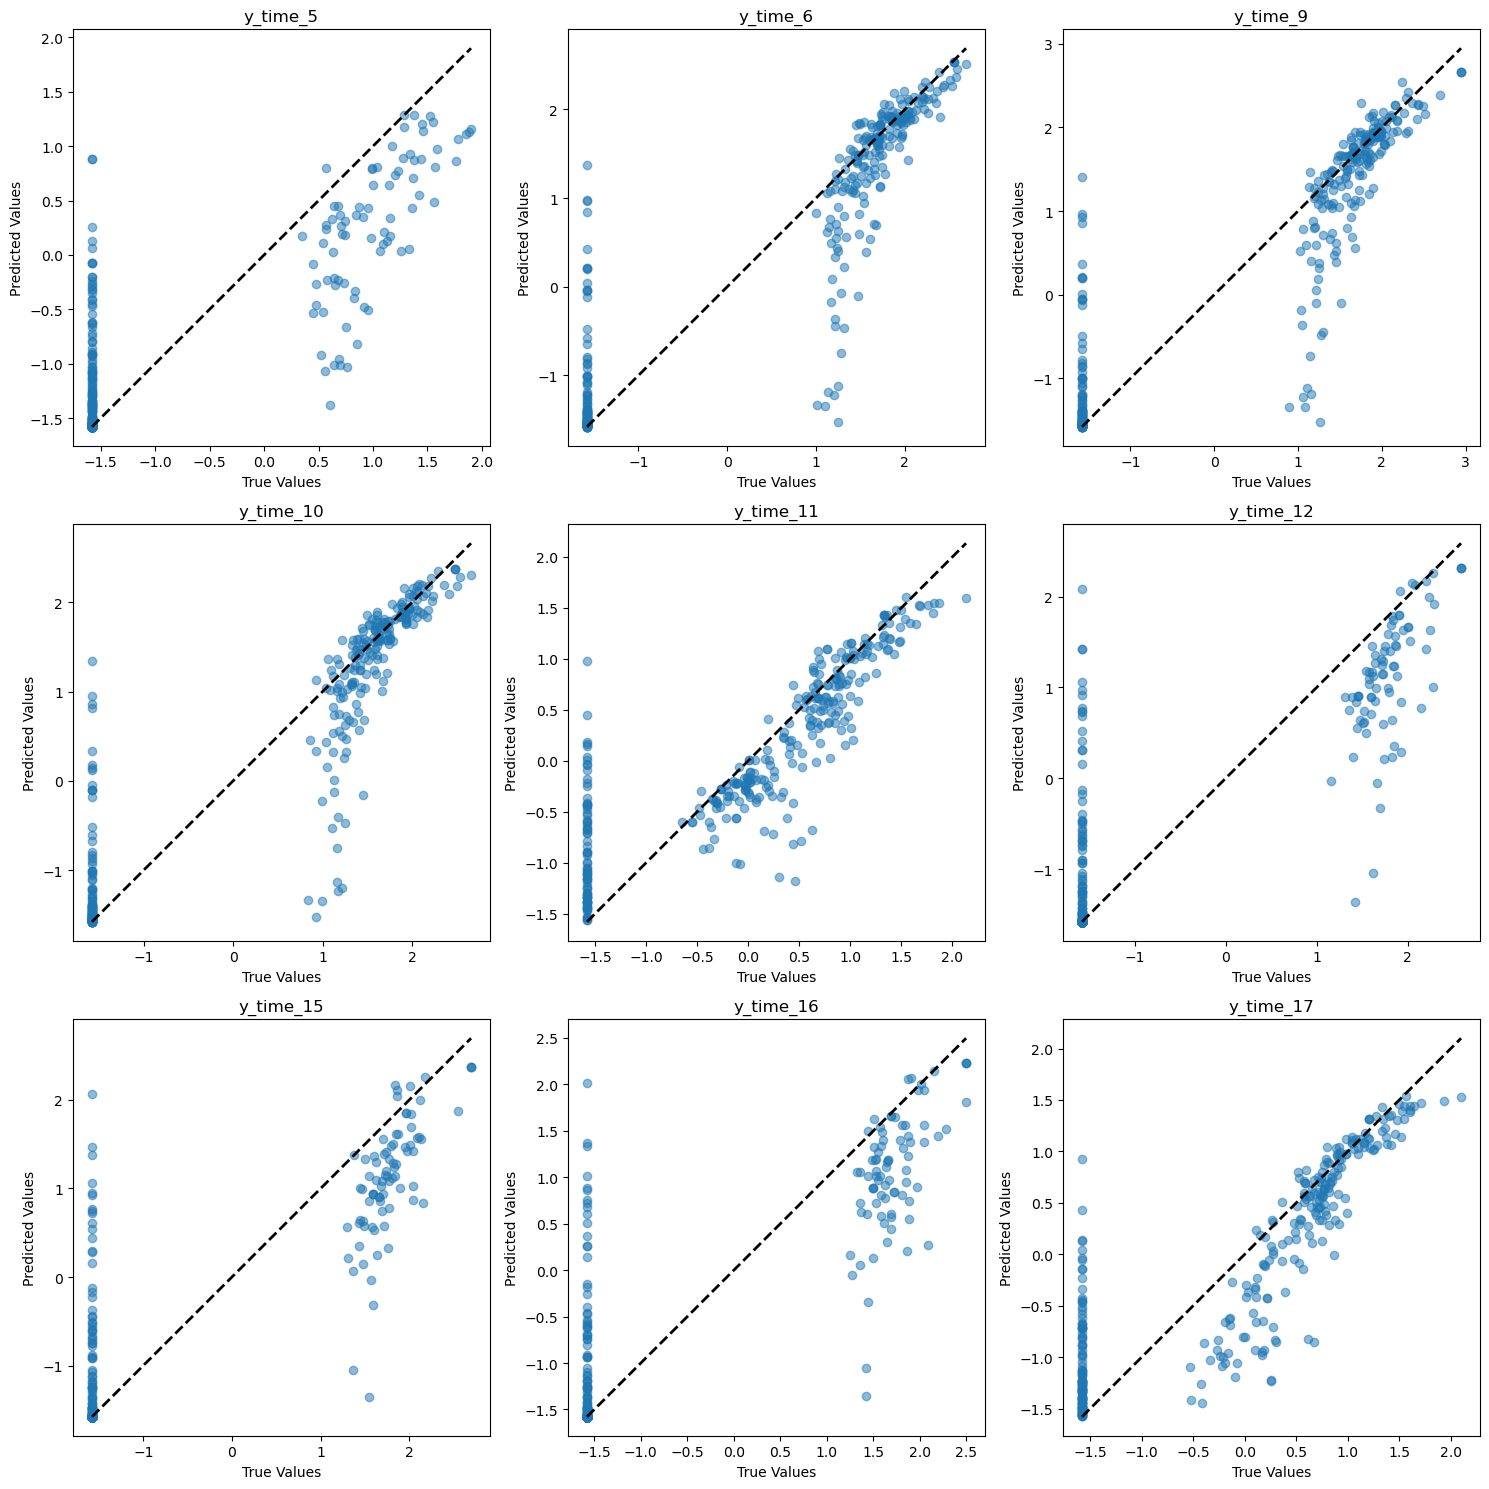

In [180]:
n_targets = len(target_cols)
n_cols = 3
n_rows = int(np.ceil(n_targets / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

axs = axs.flatten()

for i, target_name in enumerate(target_cols):
    ax = axs[i]
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    ax.set_title(f"{target_name}")
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")

# Hide unused subplots if any
for j in range(n_targets, len(axs)):
    axs[j].axis('off')

plt.tight_layout()

plt.show()


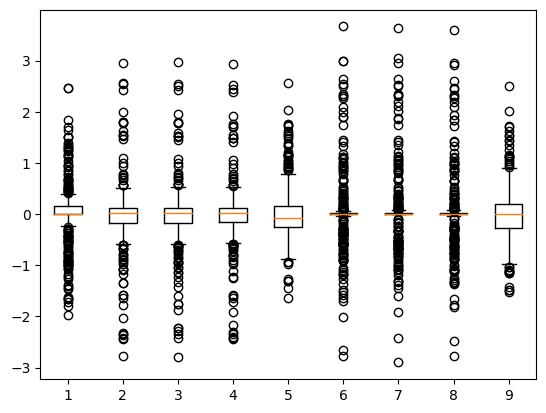

In [181]:
err= y_pred - y_test
plt.boxplot(err)
plt.show()

In [182]:
X_test[0:1].shape

(1, 20)

In [183]:
# Obtains Predictions of each decision tree for one data-point
def per_tree_preds_for_one(regressor, X_row):
    """
    X_row: shape (1, n_features) single sample 
    Returns: Y of shape (n_trees, m)
    """
    ests = getattr(regressor, "estimators_", None)
    if ests is None:
        raise ValueError("This regressor has no `estimators_` attribute.")
    Y = np.vstack([est.predict(X_row).ravel() for est in ests])  # (n_trees, m)
    return Y


# test
X_row = X_test[0:1]  # keep 2D
Y = per_tree_preds_for_one(regressor, X_row)  # (n_trees, m)

print(Y.shape)

(100, 9)


In [184]:
z = y_test.min()

In [185]:
from scipy.stats import norm

def probs_best_empirical(Y, larger_is_better=True):
    Y_eff = Y if larger_is_better else -Y
    winners = np.argmax(Y_eff, axis=1)
    m = Y.shape[1]
    return np.bincount(winners, minlength=m) / Y.shape[0]

def probs_best_softmax(Y, larger_is_better=True, tau=None):
    Y_eff = Y if larger_is_better else -Y
    if tau is None:
        s = np.std(Y_eff)
        tau = s if s > 0 else 1.0
    Z = (Y_eff - Y_eff.max(axis=1, keepdims=True)) / tau
    P = np.exp(Z); P /= P.sum(axis=1, keepdims=True)
    return P.mean(axis=0)

def probs_best_mvn_mc(Y, larger_is_better=True, n_samples=50000, rng=42):
    Y_eff = Y if larger_is_better else -Y
    mu = Y_eff.mean(axis=0)
    Sigma = np.cov(Y_eff, rowvar=False)
    lam = 1e-8 * np.trace(Sigma) / Sigma.shape[0]
    Sigma = Sigma + lam * np.eye(Sigma.shape[0])
    g = np.random.default_rng(rng)
    samples = g.multivariate_normal(mu, Sigma, size=n_samples)
    winners = np.argmax(samples, axis=1)
    m = Y.shape[1]
    return np.bincount(winners, minlength=m) / n_samples


In [186]:
j=5
# Build per-tree predictions for a single test sample
Y = per_tree_preds_for_one(regressor, X_test[j:j+1])  # (n_trees, m)

# Choose whether larger or smaller is better
larger_is_better = True   # set False if these are times-to-solution

p_emp = probs_best_empirical(Y, larger_is_better)
p_smx = probs_best_softmax(Y, larger_is_better, tau=None)
p_mvn = probs_best_mvn_mc(Y, larger_is_better, n_samples=50000, rng=42)

print("Empirical:", p_emp.round(3))
print("Softmax:  ", p_smx.round(3))
print("MVN-MC:   ", p_mvn.round(3))


Empirical: [0.01 0.01 0.03 0.   0.81 0.   0.   0.   0.14]
Softmax:   [0.039 0.05  0.051 0.05  0.374 0.038 0.038 0.038 0.324]
MVN-MC:    [0.    0.    0.001 0.    0.687 0.    0.    0.    0.311]


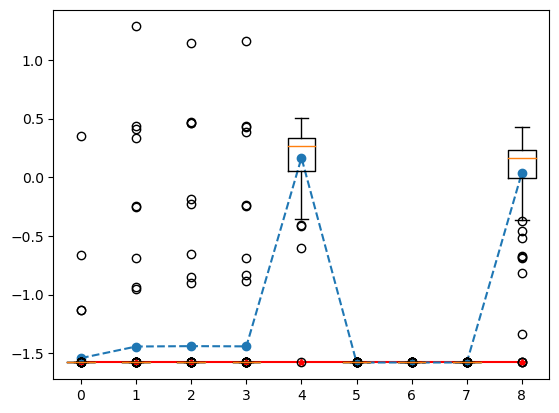

In [187]:
plt.plot(y_test[j],'r-*')
plt.plot(y_pred[j],'--o')
plt.boxplot(Y, positions = np.arange(len(y_test[j]))) 

plt.show()

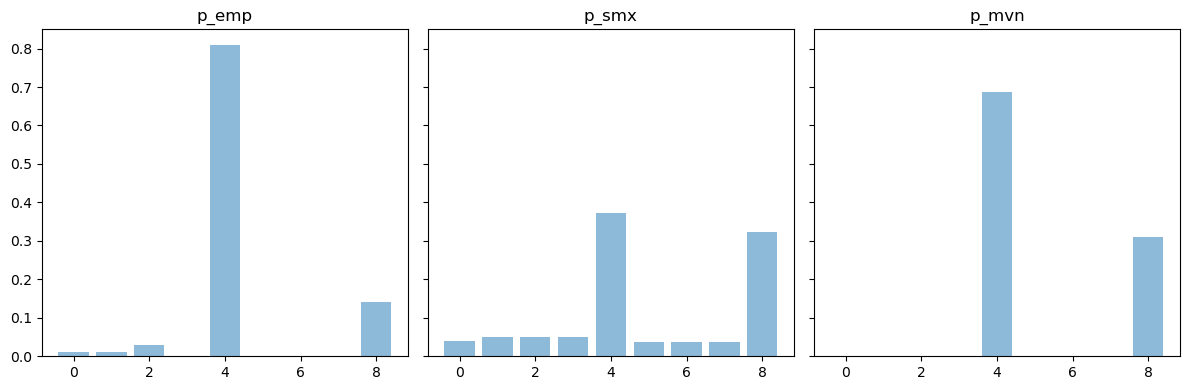

In [188]:


fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))

axs[0].bar(range(len(p_emp)), p_emp, alpha=0.5)
axs[0].set_title("p_emp")

axs[1].bar(range(len(p_smx)), p_smx, alpha=0.5)
axs[1].set_title("p_smx")

axs[2].bar(range(len(p_mvn)), p_mvn, alpha=0.5)
axs[2].set_title("p_mvn")

plt.tight_layout()
plt.show()


In [189]:
print(y_test[j])
print(y_pred[j])

[-1.57901291 -1.57901291 -1.57901291 -1.57901291 -1.57901291 -1.57901291
 -1.57901291 -1.57901291 -1.57901291]
[-1.54153575 -1.4429576  -1.4397174  -1.4417165   0.16520749 -1.57901291
 -1.57901291 -1.57901291  0.03860452]


In [190]:
z = y_test.min()
larger_is_better = True  
TOLs = 1e-6 # Toleratnce of z

BestSolver, BestSolverPred = [], []

for j in range(len(y_test)):
 
    # Build per-tree predictions for a single test sample
    Y = per_tree_preds_for_one(regressor, X_test[j:j+1])  # (n_trees, m)
    #Obtain probability of which solution is the best
    p_smx = probs_best_softmax(Y, larger_is_better, tau=None)
    k_smx = p_smx.argmax(); k_true = y_test[j].argmax()
    
    if np.abs(y_pred[j,k_smx] -z) < TOLs:
       BestSolverPred.append(None)
    else: 
        BestSolverPred.append(k_smx)      

    if y_test[j, k_true]==z:
        BestSolver.append(None)
    else: 
        BestSolver.append(k_true)      

In [191]:
same = sum(1 for a, b in zip(BestSolver, BestSolverPred) if a == b)
print(f'{same} correct predicitons out of {len(y_test)}')

none_pairs = sum(1 for a, b in zip(BestSolver, BestSolverPred) if a is None and b is None)
print(f'among them {none_pairs} diverged ')




154 correct predicitons out of 320
among them 0 diverged 


In [192]:
y_pred_best = y_pred[np.arange(len(BestSolverPred)), BestSolverPred]
y_test_best = np.max(y_test, axis = 1)

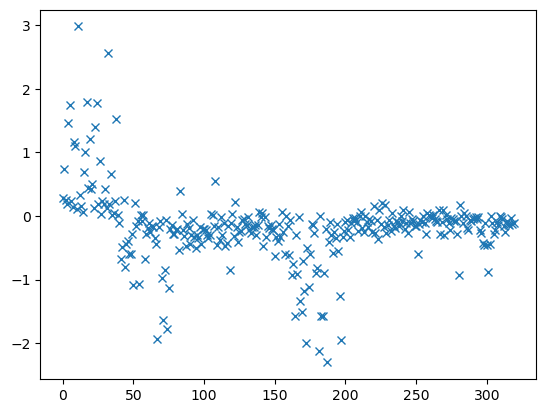

In [212]:
y_pred_best = y_pred[np.arange(len(BestSolverPred)), BestSolverPred]
err = (y_pred_best - y_test_best)
plt.plot(err, 'x')
plt.show()

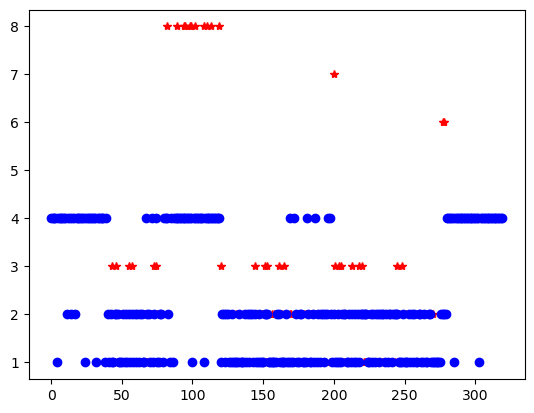

In [208]:
plt.plot(BestSolver,'r*')
plt.plot(BestSolverPred,'bo')

In [196]:
def adjusted_pred(y_pred, y_pred_class, pattern_id_to_array, T_default):
    """
    Adjusts the regression predictions based on predicted convergence pattern.

    Parameters:
    - y_pred: (n_samples, n_targets) numpy array of regression outputs.
    - y_pred_class: (n_samples,) numpy array of predicted pattern_id (from classifier).
    - pattern_id_to_array: dict {pattern_id: np.array of 0/1} mapping convergence pattern.
    - T_default: default value to assign to non-converged solvers.

    Returns:
    - y_pred_adj: (n_samples, n_targets) numpy array of adjusted predictions.
    """
    y_pred_adj = []

    for i in range(len(y_pred)):
        pattern_id = y_pred_class[i]
        mask = pattern_id_to_array[pattern_id]
        masked_row = np.where(mask == 1, y_pred[i], T_default)
        y_pred_adj.append(masked_row)

    return np.array(y_pred_adj)


In [200]:
y_pred_adjusted = adjusted_pred(y_pred, y_pred_reduced, pattern_id_to_array, T_default=z)


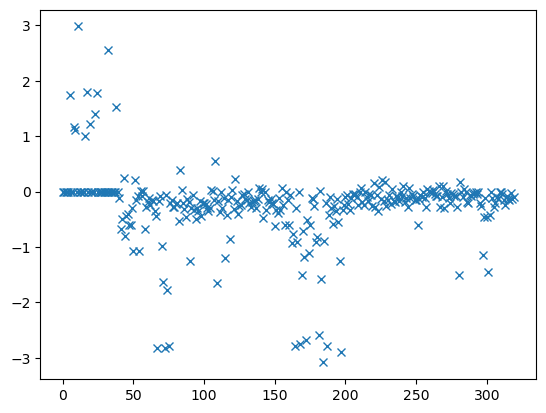

In [213]:
y_pred_best = y_pred_adjusted[np.arange(len(BestSolverPred)), BestSolverPred]
err = (y_pred_best - y_test_best)
plt.plot(err, 'x')
plt.show()

In [318]:
global_max_time

-1.5790129085478044

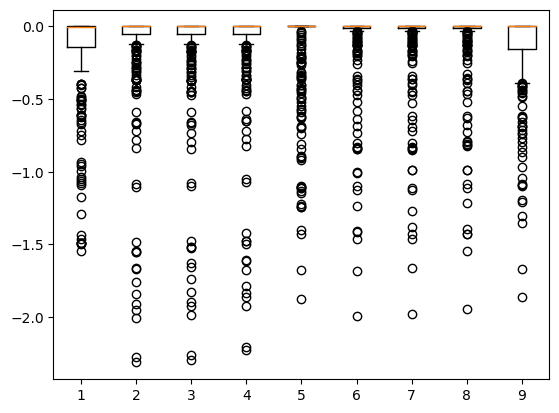

In [319]:
err= y_pred_adjusted - y_pred
plt.boxplot(err)
plt.show()

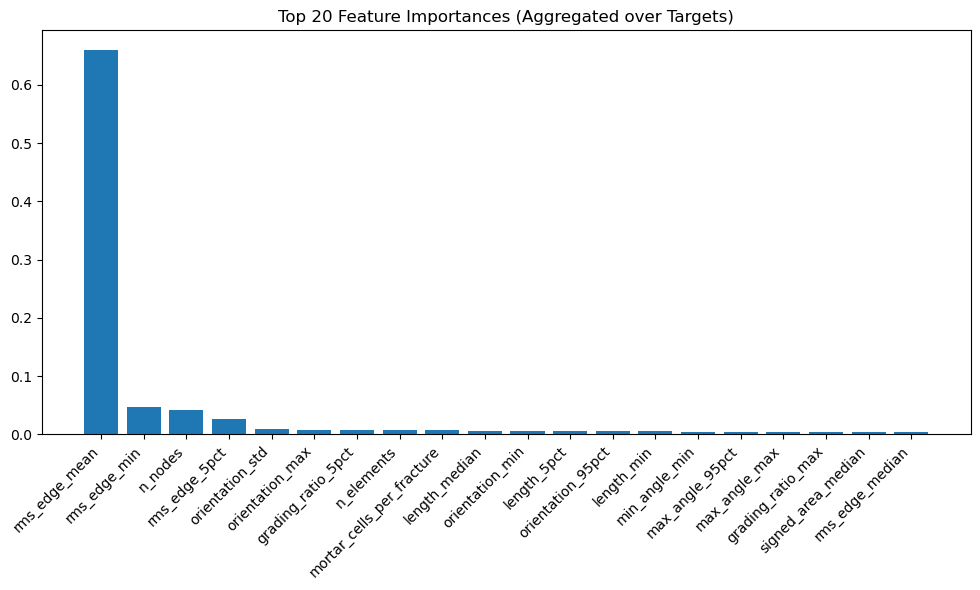

In [384]:

importances = regressor.feature_importances_
feature_names = feature_cols

sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(20), importances[sorted_idx[:20]])
plt.xticks(range(20), [feature_names[i] for i in sorted_idx[:20]], rotation=45, ha='right')
plt.title("Top 20 Feature Importances (Aggregated over Targets)")
plt.tight_layout()
plt.show()


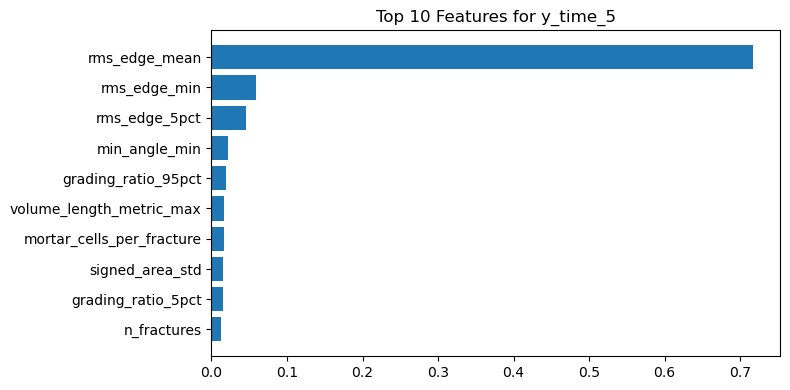

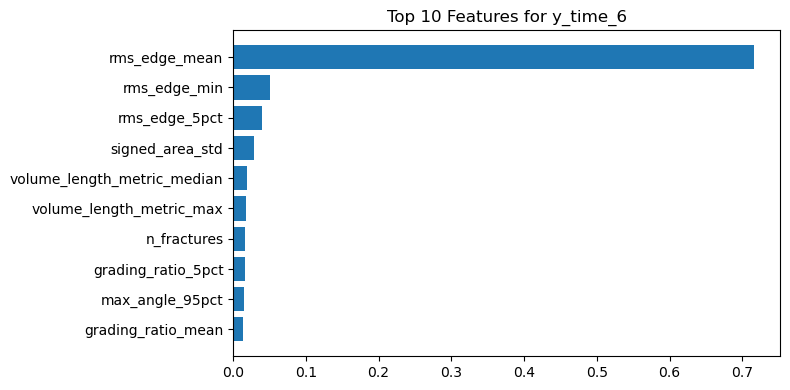

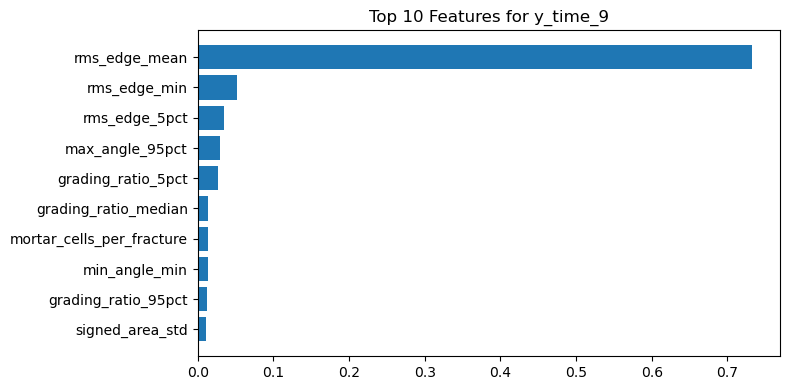

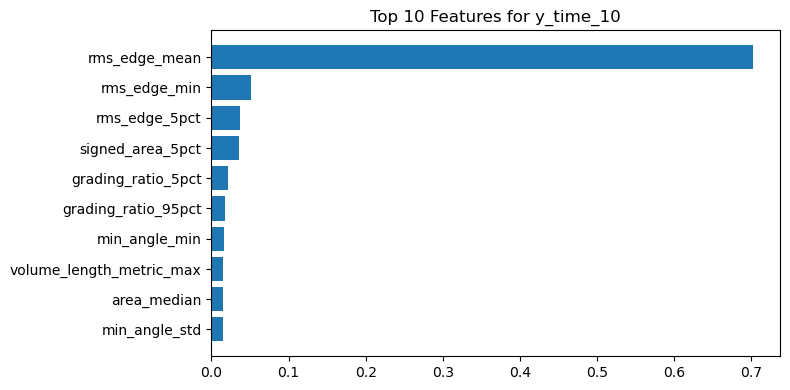

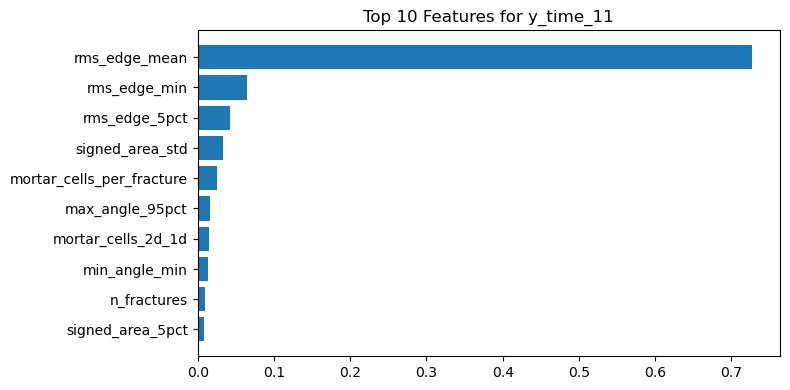

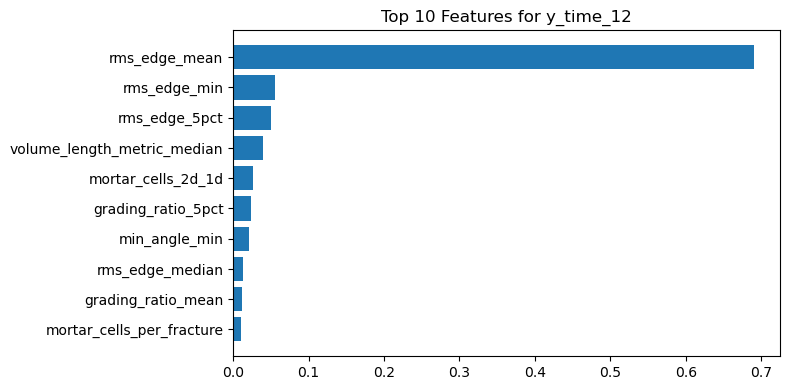

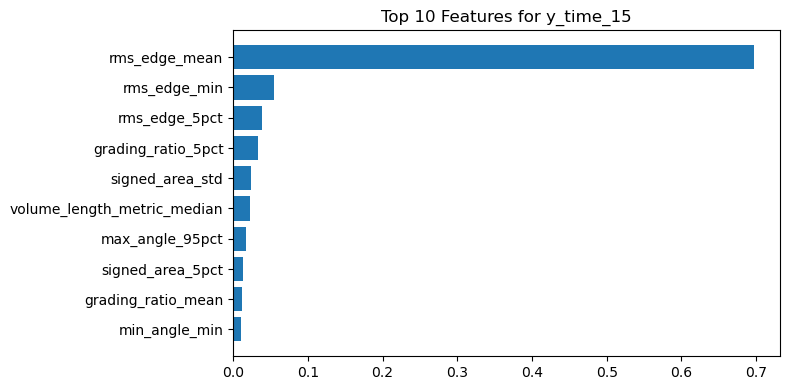

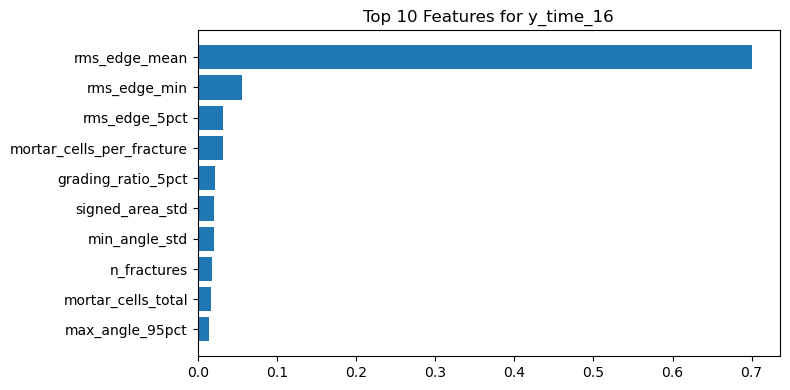

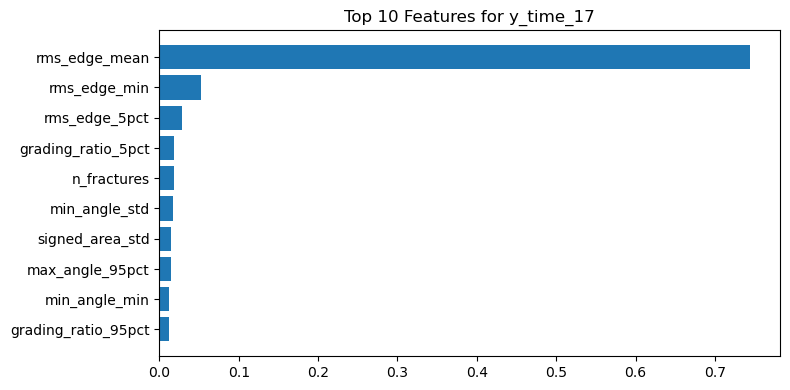

In [321]:

importances_df = pd.DataFrame()

for i, target_name in enumerate(target_cols):
    importances = regressor.estimators_[i].feature_importances_
    df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances,
        'target': target_name
    })
    importances_df = pd.concat([importances_df, df], ignore_index=True)

for target_name in target_cols:
    target_importances = (
        importances_df[importances_df['target'] == target_name]
        .sort_values('importance', ascending=False)
        .head(10)
    )
    plt.figure(figsize=(8, 4))
    plt.barh(target_importances['feature'], target_importances['importance'])
    plt.title(f"Top 10 Features for {target_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()



## Gradient Boosing Trees

In [322]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define base regressor
gbr_base = GradientBoostingRegressor(
    n_estimators=n_esti,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=rndm_state
)

# Wrap with MultiOutputRegressor
gbr = MultiOutputRegressor(gbr_base)

# Fit model
gbr.fit(X_train, y_train)

# Predict
y_pred = gbr.predict(X_test)

# Evaluate
for i, target_name in enumerate(target_cols):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"{target_name}: MSE = {mse:.4f}, R² = {r2:.4f}")


y_time_5: MSE = 0.3307, R² = 0.7430
y_time_6: MSE = 0.5179, R² = 0.8024
y_time_9: MSE = 0.5054, R² = 0.8069
y_time_10: MSE = 0.4811, R² = 0.8041
y_time_11: MSE = 0.2877, R² = 0.7414
y_time_12: MSE = 0.6435, R² = 0.6991
y_time_15: MSE = 0.6419, R² = 0.6998
y_time_16: MSE = 0.5926, R² = 0.7117
y_time_17: MSE = 0.3038, R² = 0.7759


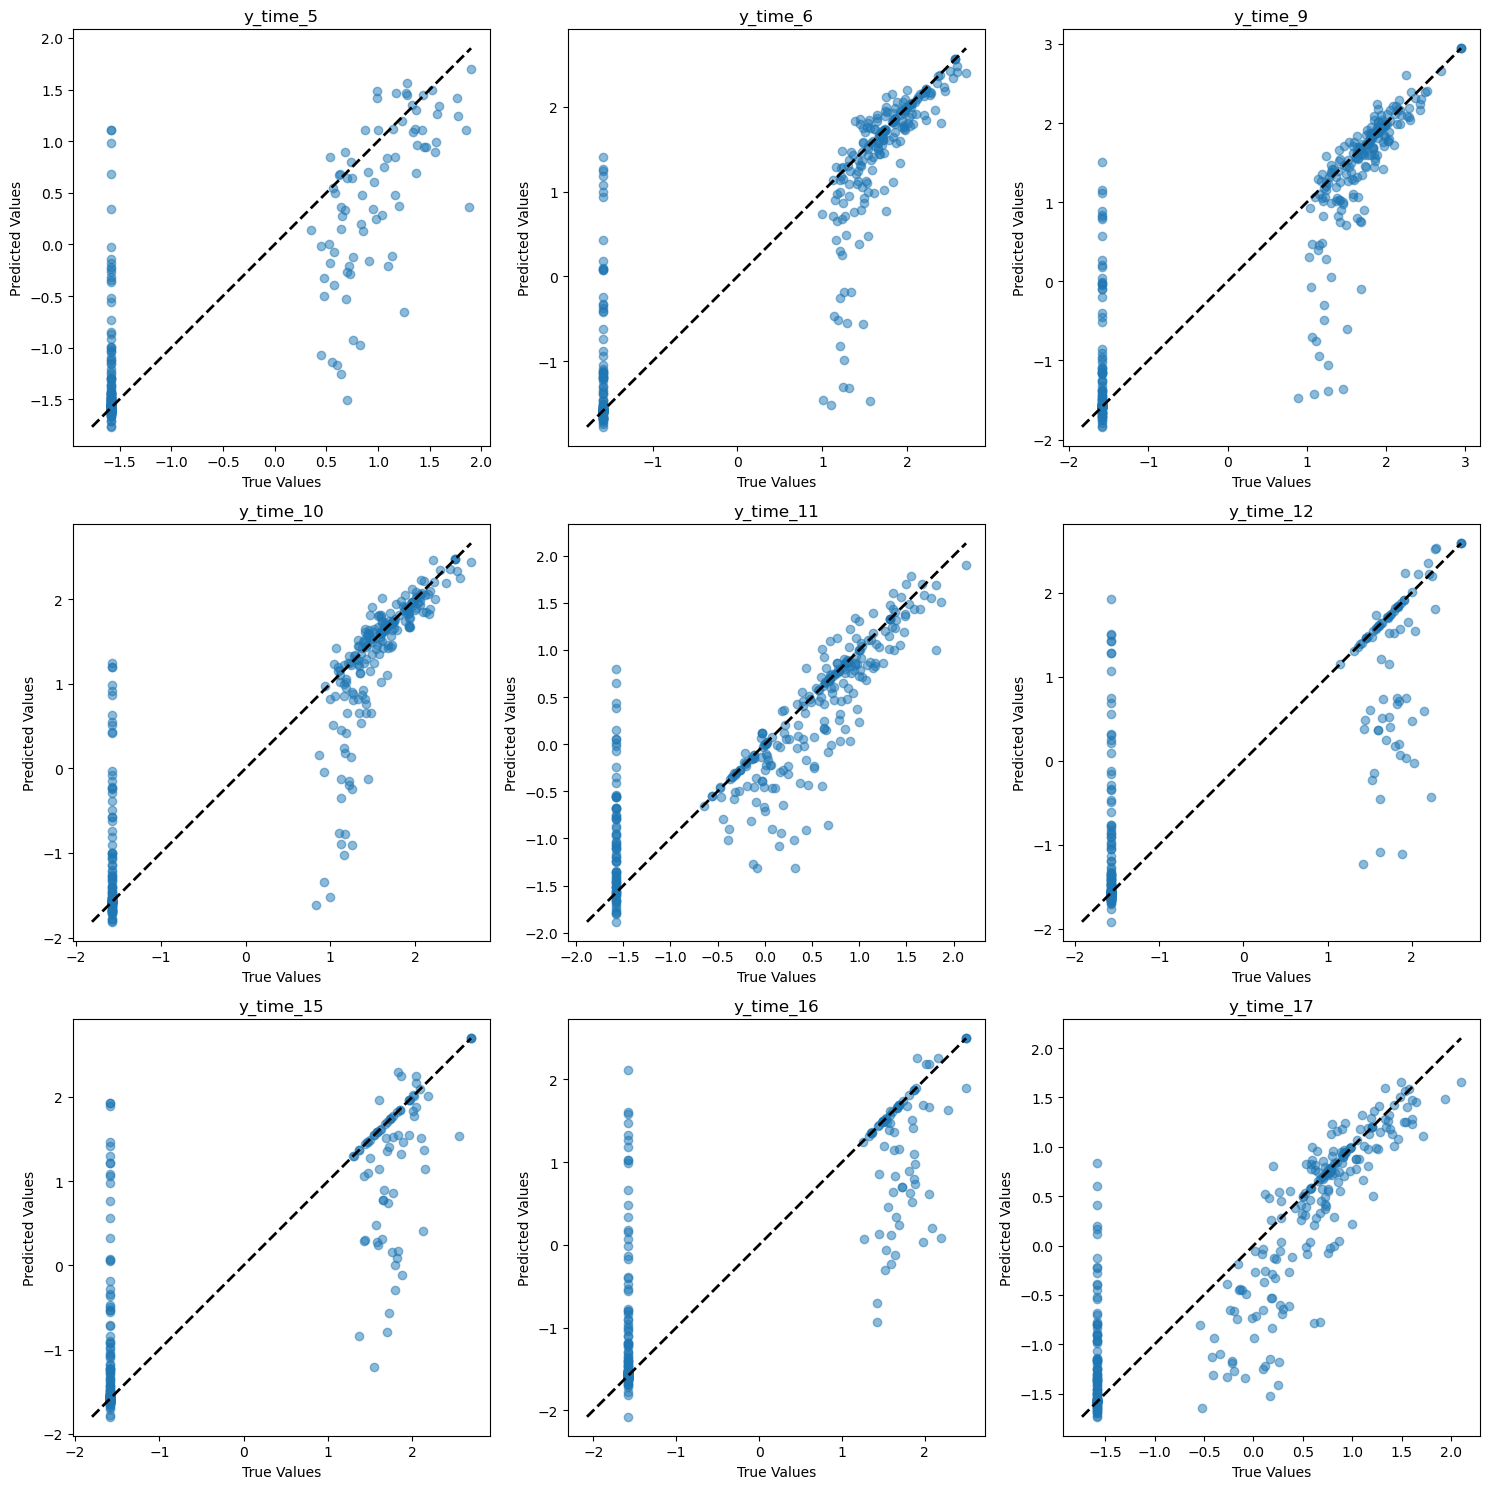

In [323]:
n_targets = len(target_cols)
n_cols = 3
n_rows = int(np.ceil(n_targets / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

axs = axs.flatten()

for i, target_name in enumerate(target_cols):
    ax = axs[i]
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    ax.set_title(f"{target_name}")
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")

# Hide unused subplots if any
for j in range(n_targets, len(axs)):
    axs[j].axis('off')

plt.tight_layout()

plt.show()

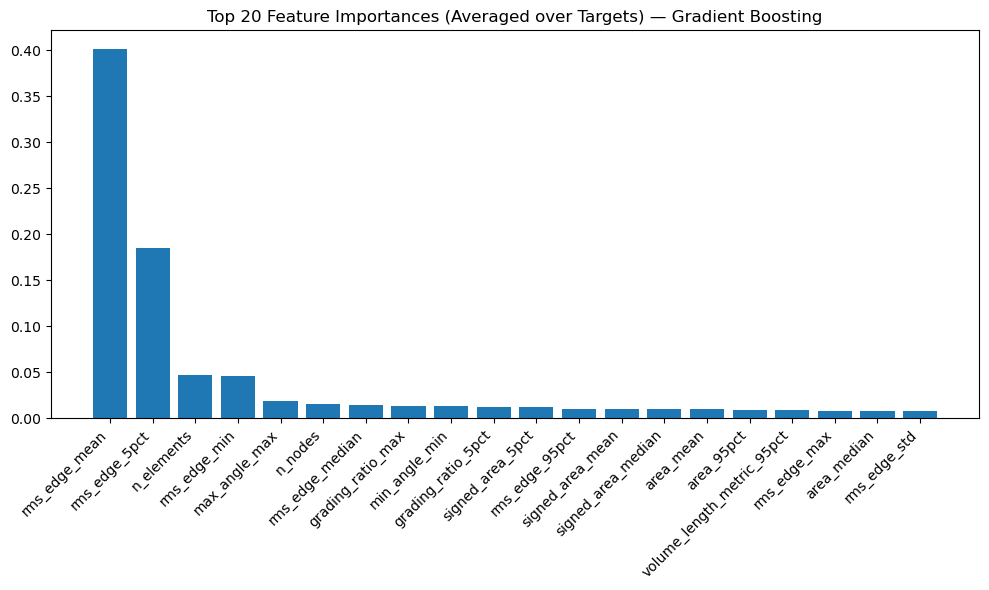

In [161]:

# Collect importances from each estimator
all_importances = []

for i, est in enumerate(gbr.estimators_):  # gbr is your MultiOutputRegressor
    importances = est.feature_importances_
    all_importances.append(importances)

# Convert to array and compute mean importance per feature
all_importances = np.array(all_importances)
mean_importances = all_importances.mean(axis=0)

# Sort and plot top 20
sorted_idx = np.argsort(mean_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(20), mean_importances[sorted_idx[:20]])
plt.xticks(range(20), [feature_cols[i] for i in sorted_idx[:20]], rotation=45, ha='right')
plt.title("Top 20 Feature Importances (Averaged over Targets) — Gradient Boosting")
plt.tight_layout()
plt.show()


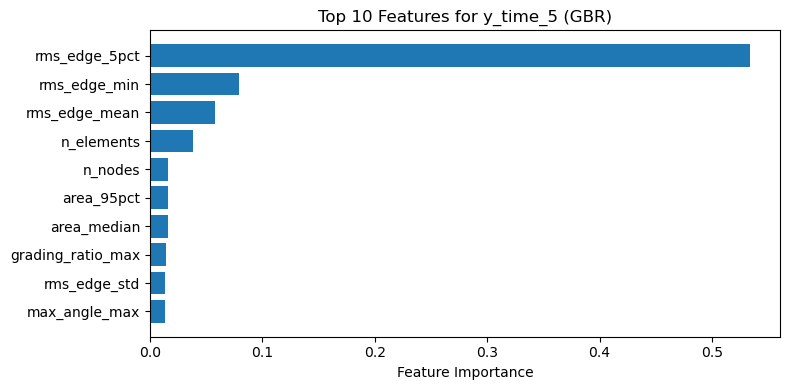

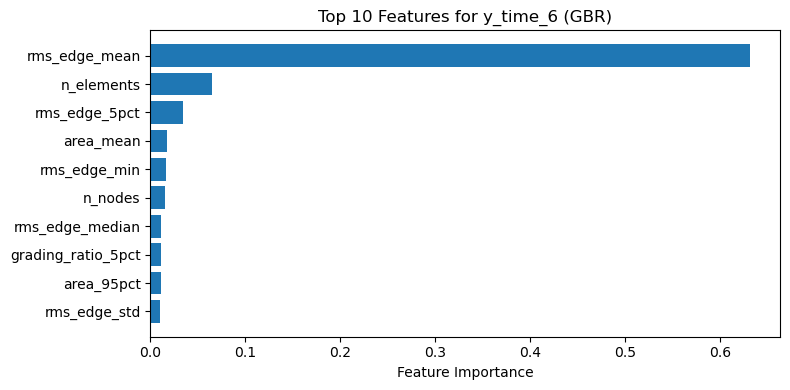

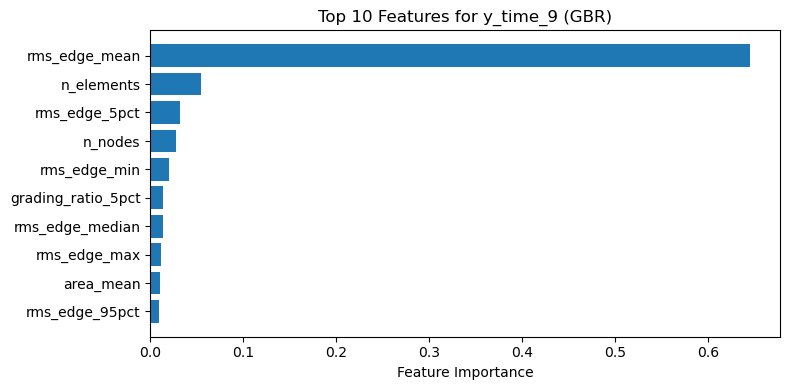

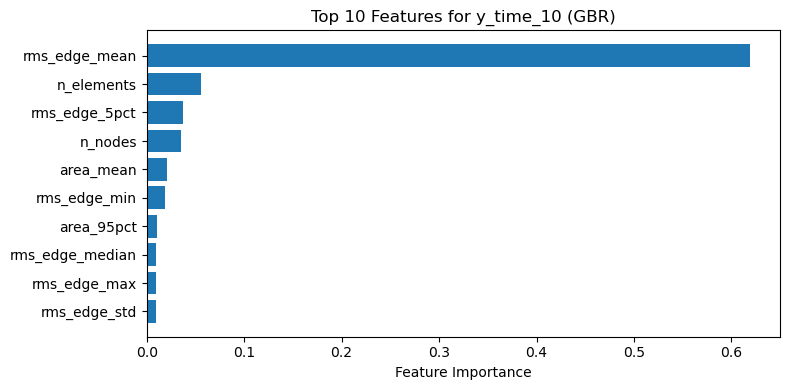

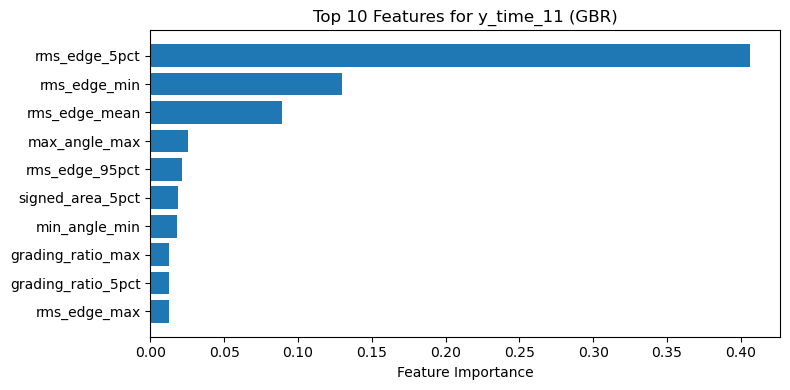

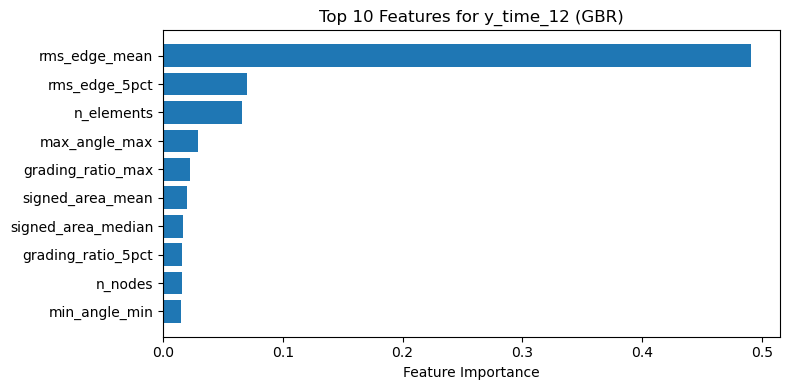

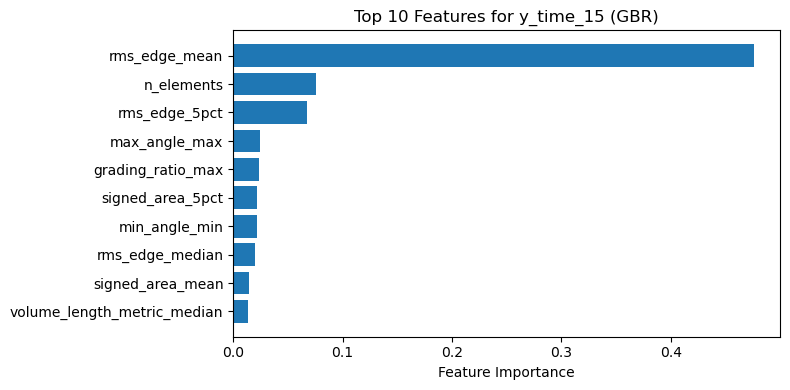

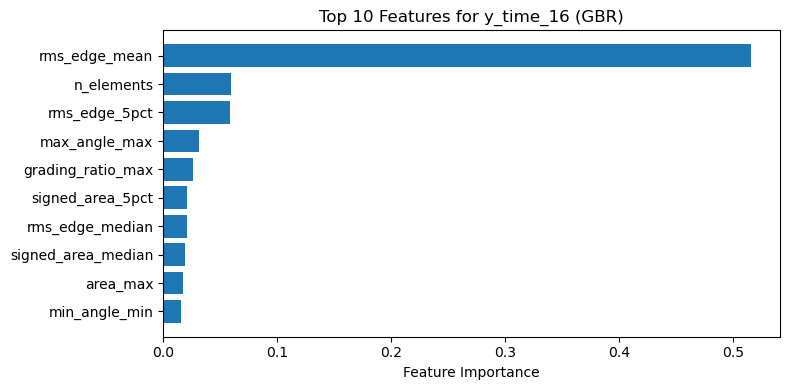

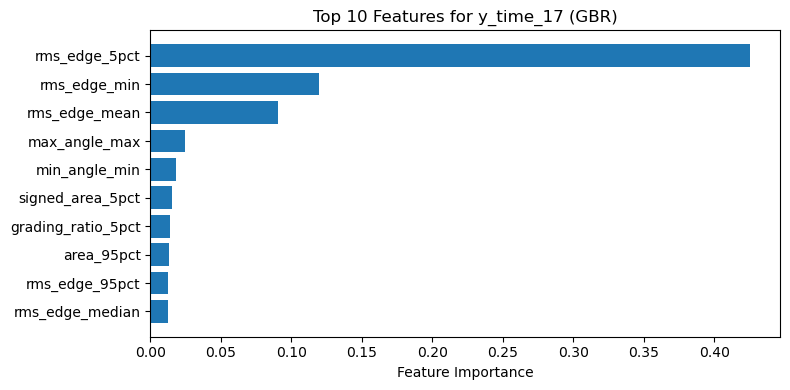

In [163]:

# Collect importances per target
importances_df = pd.DataFrame()

for i, est in enumerate(gbr.estimators_):
    importances = est.feature_importances_
    df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances,
        'target': target_cols[i]
    })
    importances_df = pd.concat([importances_df, df], ignore_index=True)

# Plot per target
for target_name in target_cols:
    target_importances = (
        importances_df[importances_df['target'] == target_name]
        .sort_values('importance', ascending=False)
        .head(10)
    )
    
    plt.figure(figsize=(8, 4))
    plt.barh(target_importances['feature'], target_importances['importance'])
    plt.title(f"Top 10 Features for {target_name} (GBR)")
    plt.xlabel("Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
